In [46]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime, timedelta
from scipy.special import gamma,gammainc,gammaincc,erf
from scipy.optimize import minimize, root_scalar
from scipy.stats import norm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from matplotlib.backends import backend_pdf as bpdf
from covid_functions import *
%matplotlib inline

#Only use data up through April 15
cutoff_time = datetime(2020,4,16)

base_url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/'

cases_global = format_JH(base_url+'time_series_covid19_confirmed_global.csv',['Lat','Long'],['Country/Region','Province/State'])
deaths_global = format_JH(base_url+'time_series_covid19_deaths_global.csv',['Lat','Long'],['Country/Region','Province/State'])
cases_US = format_JH(base_url+'time_series_covid19_confirmed_US.csv',['UID','iso2','iso3','code3','FIPS','Lat','Long_','Combined_Key'],['Country_Region','Province_State','Admin2'])
deaths_US = format_JH(base_url+'time_series_covid19_deaths_US.csv',['UID','iso2','iso3','code3','FIPS','Lat','Long_','Combined_Key','Population'],['Country_Region','Province_State','Admin2'])
cases_US = cases_US.T.groupby(level=[0,1]).sum().T
deaths_US = deaths_US.T.groupby(level=[0,1]).sum().T

cases = cases_global.join(cases_US).loc[:cutoff_time]
deaths = deaths_global.join(deaths_US).loc[:cutoff_time]
tref = pd.to_datetime('2020-01-01')
abbreviations = pd.read_csv('state_list.csv',index_col=0).squeeze().to_dict()

params_deaths_global=pd.read_csv('params_deaths_global.csv').fillna(value='NaN').set_index(['Country/Region','Province/State'])
params_cases_global=pd.read_csv('params_cases_global.csv').fillna(value='NaN').set_index(['Country/Region','Province/State'])
params_deaths=pd.read_csv('params_deaths_all.csv').fillna(value='NaN').set_index(['Country/Region','Province/State'])
params_cases=pd.read_csv('params_cases_all.csv').fillna(value='NaN').set_index(['Country/Region','Province/State'])

predictions_deaths = pd.read_csv('predictions_deaths_global.csv').fillna(value='NaN').set_index(['Country/Region','Province/State'])
for item in ['Nmax','Nmax_low','Nmax_high','sigma','sigma_low','sigma_high']:
    predictions_deaths[item] = pd.to_numeric(predictions_deaths[item])
for item in ['th','th_low','th_high']:
    predictions_deaths[item] = pd.to_datetime(predictions_deaths[item],format='%Y-%m-%d')
predictions_cases = pd.read_csv('predictions_cases_global.csv').fillna(value='NaN').set_index(['Country/Region','Province/State'])
for item in ['Nmax','Nmax_low','Nmax_high','sigma','sigma_low','sigma_high']:
    predictions_cases[item] = pd.to_numeric(predictions_cases[item])
for item in ['th','th_low','th_high']:
    predictions_cases[item] = pd.to_datetime(predictions_cases[item],format='%Y-%m-%d')

# Look at current numbers

In [2]:
deaths.iloc[-1].sort_values(ascending=False).iloc[:70]

Country/Region      Province/State
US                  NaN               28326
Italy               NaN               21645
Spain               NaN               18708
France              NaN               17167
United Kingdom      NaN               12868
US                  New York          11617
Iran                NaN                4777
Belgium             NaN                4440
Germany             NaN                3804
China               Hubei              3222
US                  New Jersey         3156
Netherlands         NaN                3134
US                  Michigan           1921
Brazil              NaN                1736
Turkey              NaN                1518
Switzerland         NaN                1239
Sweden              NaN                1203
US                  Massachusetts      1108
                    Louisiana          1103
                    Illinois            949
                    Connecticut         868
                    California          8

In [3]:
cases.iloc[-1].sort_values(ascending=False).iloc[:100]

Country/Region  Province/State      
US              NaN                     636350
                New York                214454
Spain           NaN                     177644
Italy           NaN                     165155
Germany         NaN                     134753
France          NaN                     133470
United Kingdom  NaN                      98476
Iran            NaN                      76389
US              New Jersey               71030
Turkey          NaN                      69392
China           Hubei                    67803
Belgium         NaN                      33573
US              Massachusetts            29918
Brazil          NaN                      28320
Netherlands     NaN                      28153
US              Michigan                 28059
                Pennsylvania             26753
                California               26686
Switzerland     NaN                      26336
US              Illinois                 24593
Russia          NaN    

# Make fits

In [10]:
params_cases = fit_all(cases,plot=False,ylabel='Confirmed Cases',p0=5e2)
params_deaths = fit_all(deaths,plot=False,ylabel='Fatalities',p0=50)
params_cases.dropna().to_csv('params_cases_all.csv')
params_deaths.dropna().to_csv('params_deaths_all.csv')

# Early exponential to power law behavior

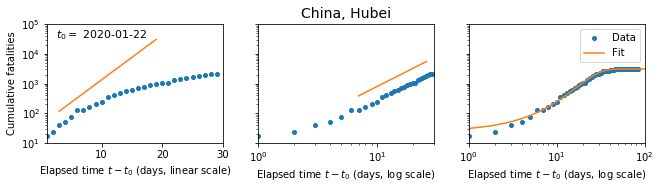

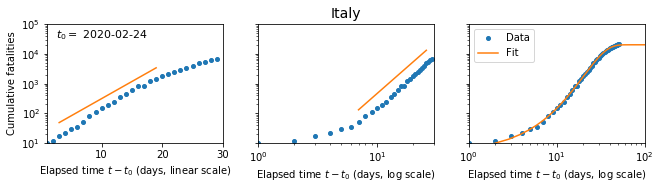

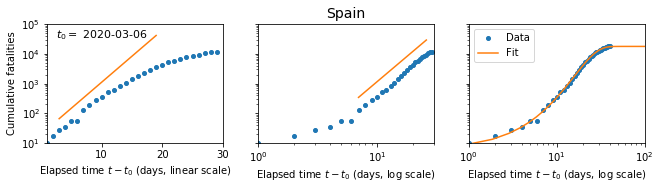

In [205]:
start_cutoff = 5
use_times = 30
ms = 4
daymin=-150
daymax=100
t_pred = pd.to_datetime([datetime.today()+timedelta(days=k) for k in range(daymin,daymax)])

for country,region in [('China','Hubei'),('Italy','NaN'),('Spain','NaN')]:
    data = deaths[country,region]
    params = params_deaths.loc[country,region]

    fig,ax=plt.subplots(1,3,sharey=True,figsize=(10,2.5))
    fig.subplots_adjust(left=0.15,bottom=0.22,right=0.98)

    plot_data = data.loc[data>=start_cutoff]
    t0 = plot_data.index.values[0]
    plot_data.index = (plot_data.index-t0)/timedelta(days=1)
    plot_data = plot_data.loc[plot_data.index<use_times]
    t_plot = plot_data.index.values
    ax[1].loglog(t_plot,plot_data.values,'o',label='data',markersize=ms)
    ax[0].semilogy(t_plot,plot_data.values,'o',label='data',markersize=ms)

    fit_early = plot_data.iloc[:7]
    fit_late = plot_data.iloc[7:-3]
    t_fit_early = fit_early.index.values
    t_fit_late = fit_late.index.values
    expo = LinearRegression()
    expo2 = LinearRegression()
    power = LinearRegression()
    X_all = plot_data.index.values[3:20].reshape(-1,1)
    y_all = np.log(pd.to_numeric(plot_data).iloc[3:20].values)
    X_early = t_fit_early.reshape(-1,1)
    X_late = t_fit_late.reshape(-1,1)
    y_early = np.log(pd.to_numeric(fit_early).values)
    y_late = np.log(pd.to_numeric(fit_late).values)
    expo.fit(X_early,y_early)
    #expo2.fit(X_late,y_late)
    power.fit(np.log(X_late),y_late)
    y_power = power.predict(np.log(X_late))
    y_exp = expo.predict(X_all)
    #exp_score2 = expo2.score(X_all,y_all)
    ax[1].loglog(X_late.reshape(-1),3*np.exp(y_power))
    ax[0].semilogy(X_all.reshape(-1),3*np.exp(y_exp))
    out = plot_predictions(data,params,ax=ax[2],log_scale=True,conf_type=None,p0=50,t_pred = t_pred)

    ax[0].set_xlabel(r'Elapsed time $t-t_0$ (days, linear scale)')
    ax[1].set_xlabel(r'Elapsed time $t-t_0$ (days, log scale)')
    ax[2].set_xlabel(r'Elapsed time $t-t_0$ (days, log scale)')
    ax[0].set_ylabel('Cumulative fatalities')
    #ax[0].set_title(country+', '+region)
    ax[0].set_ylim((10,1e5))
    if country == 'China':
        ax[1].set_title(', '.join([country,region]),fontsize=14)
    else:
        ax[1].set_title(country,fontsize=14)
    ax[2].legend()
    ax[0].set_xlim((1,use_times))
    ax[1].set_xlim((1,use_times))
    ax[2].set_xlim((1,100))
    ax[0].text(0.05,0.88,r'$t_0 = $ '+np.datetime_as_string(t0)[:10],fontsize=11,transform=ax[0].transAxes)
    
    pdf = bpdf.PdfPages('figures/example_'+country+'.pdf')
    pdf.savefig(fig)
    pdf.close()
    plt.show()

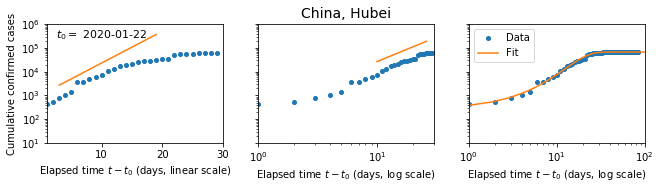

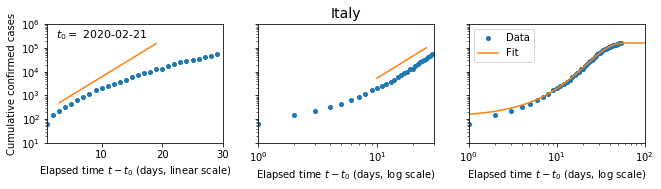

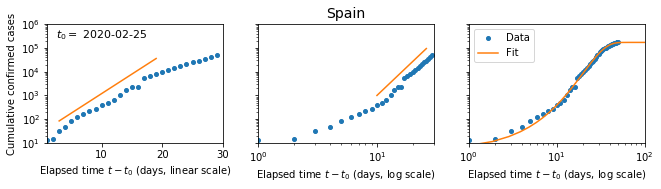

In [207]:
start_cutoff = 5
use_times = 30
ms = 4
daymin=-150
daymax=100
t_pred = pd.to_datetime([datetime.today()+timedelta(days=k) for k in range(daymin,daymax)])

for country,region in [('China','Hubei'),('Italy','NaN'),('Spain','NaN')]:
    data = cases[country,region]
    params = params_cases.loc[country,region]

    fig,ax=plt.subplots(1,3,sharey=True,figsize=(10,2.5))
    fig.subplots_adjust(left=0.15,bottom=0.22,right=0.98)

    plot_data = data.loc[data>=start_cutoff]
    t0 = plot_data.index.values[0]
    plot_data.index = (plot_data.index-t0)/timedelta(days=1)
    plot_data = plot_data.loc[plot_data.index<use_times]
    t_plot = plot_data.index.values
    ax[1].loglog(t_plot,plot_data.values,'o',label='data',markersize=ms)
    ax[0].semilogy(t_plot,plot_data.values,'o',label='data',markersize=ms)

    fit_early = plot_data.iloc[:14]
    fit_late = plot_data.iloc[10:-3]
    t_fit_early = fit_early.index.values
    t_fit_late = fit_late.index.values
    expo = LinearRegression()
    expo2 = LinearRegression()
    power = LinearRegression()
    X_all = plot_data.index.values[3:20].reshape(-1,1)
    y_all = np.log(pd.to_numeric(plot_data).iloc[3:20].values)
    X_early = t_fit_early.reshape(-1,1)
    X_late = t_fit_late.reshape(-1,1)
    y_early = np.log(pd.to_numeric(fit_early).values)
    y_late = np.log(pd.to_numeric(fit_late).values)
    expo.fit(X_early,y_early)
    #expo2.fit(X_late,y_late)
    power.fit(np.log(X_late),y_late)
    y_power = power.predict(np.log(X_late))
    y_exp = expo.predict(X_all)
    #exp_score2 = expo2.score(X_all,y_all)
    ax[1].loglog(X_late.reshape(-1),3*np.exp(y_power))
    ax[0].semilogy(X_all.reshape(-1),3*np.exp(y_exp))
    out = plot_predictions(data,params,ax=ax[2],log_scale=True,conf_type=None,p0=500,
                           t_pred = t_pred,start_cutoff=start_cutoff)
    ax[0].text(0.05,0.88,r'$t_0 = $ '+np.datetime_as_string(t0)[:10],fontsize=11,transform=ax[0].transAxes)
    ax[0].set_xlabel(r'Elapsed time $t-t_0$ (days, linear scale)')
    ax[1].set_xlabel(r'Elapsed time $t-t_0$ (days, log scale)')
    ax[2].set_xlabel(r'Elapsed time $t-t_0$ (days, log scale)')
    ax[0].set_ylabel('Cumulative confirmed cases')
    #ax[0].set_title(country+', '+region)
    ax[0].set_ylim((10,1e6))
    if country == 'China':
        ax[1].set_title(', '.join([country,region]),fontsize=14)
    else:
        ax[1].set_title(country,fontsize=14)
    ax[2].legend()
    ax[0].set_xlim((1,use_times))
    ax[1].set_xlim((1,use_times))
    ax[2].set_xlim((1,100))
    
    pdf = bpdf.PdfPages('figures/example_'+country+'_cases.pdf')
    pdf.savefig(fig)
    pdf.close()
    plt.show()

# Diagnostic plots

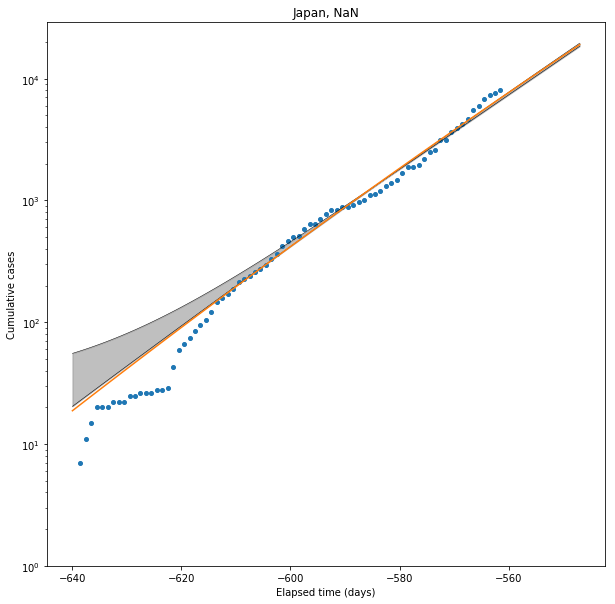

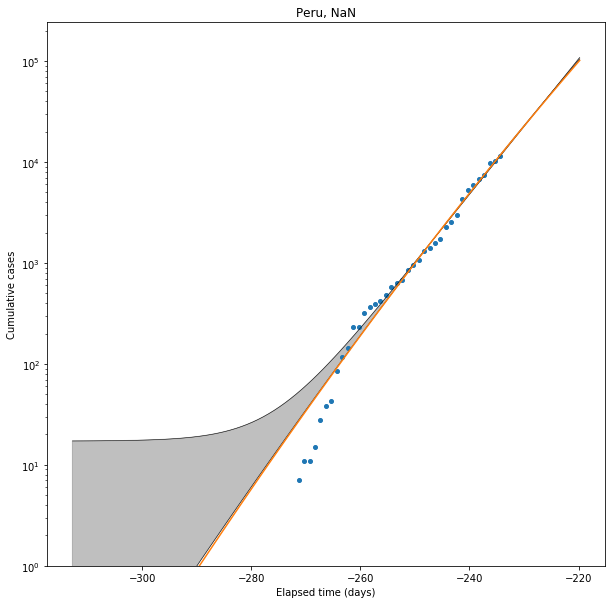

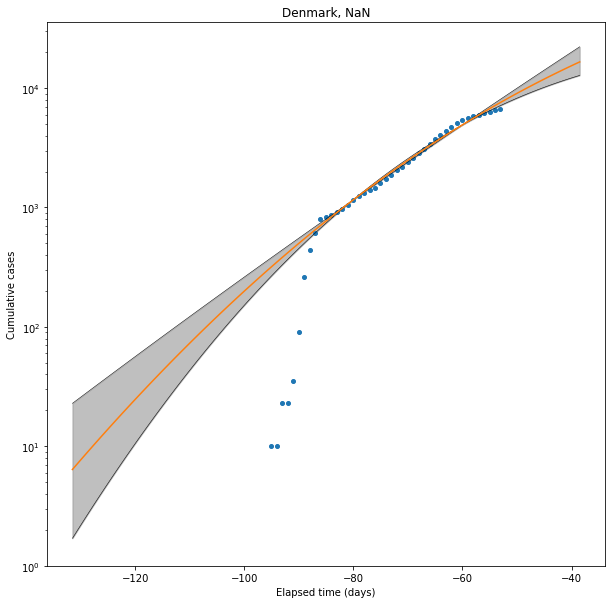

In [17]:
for country, region in [('Japan','NaN'),('Peru','NaN'),('Denmark','NaN')]:
    params = params_cases.loc[country,region]
    data = cases[country,region]
    p0 = 500
    daymin=-80
    daymax=14
    c=0.95
    t_pred = pd.to_datetime([datetime.today()+timedelta(days=k) for k in range(daymin,daymax)])

    fig,ax=plt.subplots(figsize=(10,10))
    f,a,params_good = plot_predictions(data,params,p0=p0,conf_type='sigma',log_scale=False,
                                           t_pred=t_pred,ax=ax,c=c)
    ax.set_title(country+', '+region)
    ax.set_xlabel('Elapsed time (days)')
    ax.set_ylabel('Cumulative cases')
    #ax.set_xlim((20,None))
    ax.set_ylim((1,None))
    plt.show()

th       203.280338
logK      11.215860
sigma     35.332746
score      0.001965
Name: (Dominican Republic, NaN), dtype: float64


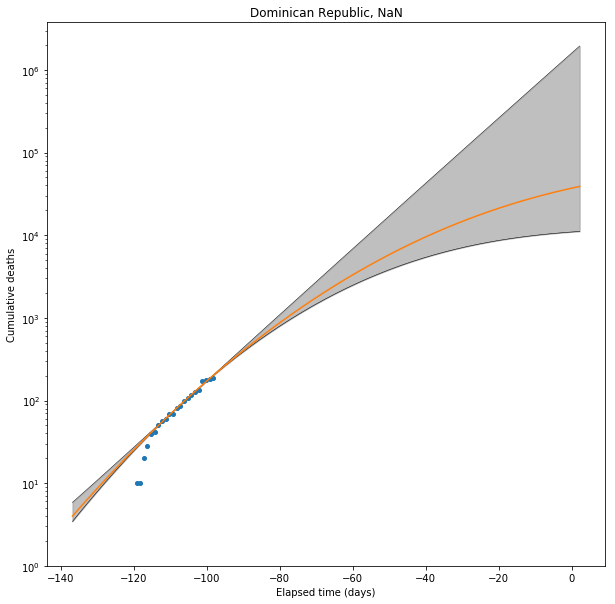

In [3]:
for country,region in [('Dominican Republic','NaN')]:
    params = params_deaths.loc[country,region]
    print(params)
    start_cutoff=5
    data = deaths[country,region]
    p0 = 50
    daymin=-40
    daymax=100
    c=0.95
    t_pred = pd.to_datetime([datetime.today()+timedelta(days=k) for k in range(daymin,daymax)])

    fig,ax=plt.subplots(figsize=(10,10))
    f,a,params_good = plot_predictions(data,params,p0=p0,conf_type='sigma',log_scale=False,
                                           t_pred=t_pred,ax=ax,c=c)
    ax.set_title(country+', '+region)
    ax.set_xlabel('Elapsed time (days)')
    ax.set_ylabel('Cumulative deaths')
    #ax.set_xlim((10,80))
    ax.set_ylim((1,None))
    plt.show()

# Make predictions

## World

In [12]:
print('Total regions = '+str(len(deaths.T)))
print('Analyzed regions = '+str(len(params_deaths.drop((('US','NaN'))).dropna())))
print('Analyzed states = '+str(len(params_deaths.dropna().loc['US'].drop('NaN'))))

Total regions = 322
Analyzed regions = 79
Analyzed states = 30


In [17]:
params_list = params_deaths
data = deaths
p0 = 50
c=0.95
current_fatalities = deaths.iloc[-1]
fit_countries = list(set(current_fatalities.index.tolist()).intersection(set(params_deaths.index.tolist())))
current_fatalities = current_fatalities.loc[fit_countries].sort_values(ascending=False)
top_countries = current_fatalities.index

predictions = []
for item in top_countries:
    print(item[0]+', '+item[1])
    train = data[item]
    params = params_list.loc[item].copy()
    try:
        params_sweep = sweep_sigma(params,train,p0)
        sigma,prob,scoremax = get_score_thresh(params_sweep,len(train.loc[train>p0]),c)
        params_good = params_sweep[params_sweep[:,3]<=scoremax]
        total = np.exp(params_good[:,1])
        th = [pd.Timestamp.isoformat((tref+pd.to_timedelta(params_good[:,0],unit='days'))[k])[:10] for k in range(len(params_good))]
        sigma = params_good[:,2]
        best = np.argmin(params_good[:,-1])
        predictions.append([total[best],total[0],total[-1],sigma[best],sigma[0],sigma[-1],th[best],th[0],th[-1]])
    except:
        print('---------------Failed---------------')
        current_fatalities = current_fatalities.drop(item)
top_countries = current_fatalities.index
predictions = pd.DataFrame(predictions,index=top_countries,columns=['Nmax','Nmax_low','Nmax_high','sigma','sigma_low','sigma_high','th','th_low','th_high'])
predictions_deaths = predictions.copy()
predictions_deaths.to_csv('predictions_deaths_global.csv')

US, NaN
Italy, NaN
Spain, NaN
France, NaN
United Kingdom, NaN
US, New York
Iran, NaN
Belgium, NaN
Germany, NaN
China, Hubei
US, New Jersey
Netherlands, NaN
US, Michigan
Brazil, NaN
Turkey, NaN
Switzerland, NaN
Sweden, NaN
US, Massachusetts
US, Louisiana
US, Illinois
US, Connecticut
US, California
US, Pennsylvania
Portugal, NaN
US, Florida
US, Washington
US, Georgia
Canada, Quebec
Indonesia, NaN
Ireland, NaN
US, Indiana
Mexico, NaN
India, NaN
Austria, NaN
Ecuador, NaN
Canada, Ontario
US, Texas
Romania, NaN
US, Ohio
Philippines, NaN
Algeria, NaN
US, Colorado
US, Maryland
Denmark, NaN
Poland, NaN
Peru, NaN
Korea, South, NaN
Russia, NaN
US, Virginia
Dominican Republic, NaN
US, Wisconsin
Egypt, NaN
Czechia, NaN
US, Missouri
Norway, NaN
Japan, NaN
US, Arizona
Hungary, NaN
Colombia, NaN
US, Nevada
US, North Carolina
Israel, NaN
Morocco, NaN
US, Tennessee
US, Oklahoma
US, Mississippi
US, Alabama
US, Kentucky
Pakistan, NaN
Argentina, NaN
Ukraine, NaN
US, South Carolina
Greece, NaN
Serbia, NaN
P

In [2]:
params_list = params_cases
data = cases
p0 = 500
c=0.95
current_cases = data.iloc[-1]
fit_countries = list(set(current_cases.index.tolist()).intersection(set(params_list.index.tolist())))
current_cases = current_cases.loc[fit_countries].sort_values(ascending=False)
top_countries = current_cases.index

predictions = []
for item in top_countries:
    print(item[0]+', '+item[1])
    train = data[item]
    params = params_list.loc[item].copy()
    try:
        params_sweep = sweep_sigma(params,train,p0)
        sigma,prob,scoremax = get_score_thresh(params_sweep,len(train),c)
        params_good = params_sweep[params_sweep[:,3]<=scoremax]
        total = np.exp(params_good[:,1])
        th = [pd.Timestamp.isoformat((tref+pd.to_timedelta(params_good[:,0],unit='days'))[k])[:10] for k in range(len(params_good))]
        sigma = params_good[:,2]
        best = np.argmin(params_good[:,-1])
        predictions.append([total[best],total[0],total[-1],sigma[best],sigma[0],sigma[-1],th[best],th[0],th[-1]])
    except:
        print('---------------Failed---------------')
        current_cases = current_cases.drop(item)
top_countries = current_cases.index
predictions = pd.DataFrame(predictions,index=top_countries,columns=['Nmax','Nmax_low','Nmax_high','sigma','sigma_low','sigma_high','th','th_low','th_high'])
predictions_cases = predictions.copy()
predictions_cases.to_csv('predictions_cases_global.csv')

US, NaN
US, New York
Spain, NaN
Italy, NaN
Germany, NaN
France, NaN
United Kingdom, NaN
Iran, NaN
US, New Jersey
Turkey, NaN
China, Hubei
Belgium, NaN
US, Massachusetts
Brazil, NaN
Netherlands, NaN
US, Michigan
US, Pennsylvania
US, California
Switzerland, NaN
US, Illinois
Russia, NaN
US, Florida
US, Louisiana
Portugal, NaN
US, Texas
US, Georgia
Canada, Quebec
US, Connecticut
Austria, NaN
Ireland, NaN
Israel, NaN
India, NaN
Sweden, NaN
Peru, NaN
US, Washington
Korea, South, NaN
US, Maryland
US, Indiana
Canada, Ontario
Chile, NaN
Japan, NaN
US, Colorado
Ecuador, NaN
US, Ohio
Poland, NaN
Romania, NaN
Norway, NaN
Denmark, NaN
US, Virginia
Pakistan, NaN
Czechia, NaN
Saudi Arabia, NaN
US, Tennessee
Philippines, NaN
Mexico, NaN
United Arab Emirates, NaN
US, North Carolina
Indonesia, NaN
Malaysia, NaN
Serbia, NaN
US, Missouri
US, Alabama
US, Arizona
Ukraine, NaN
Belarus, NaN
US, Wisconsin
Qatar, NaN
Singapore, NaN
US, South Carolina
Dominican Republic, NaN
Panama, NaN
Luxembourg, NaN
US, Missi

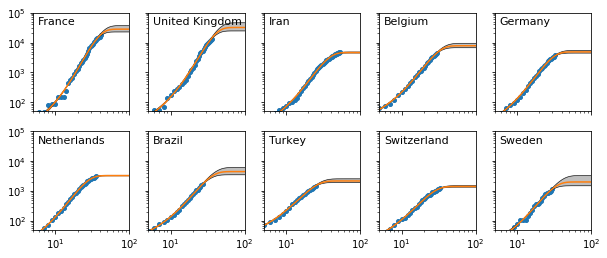

In [6]:
params_list = params_deaths
data = deaths
p0 = 50
daymin=-100
daymax=100
thresh = 500
c=0.95
drop_list = ['US','China','Italy','Spain']
current_fatalities = deaths.iloc[-1]
current_fatalities = current_fatalities.sort_index().drop(drop_list).loc[current_fatalities>thresh].sort_values(ascending=False)
top_countries = current_fatalities.index[:10]
t_pred = pd.to_datetime([datetime.today()+timedelta(days=k) for k in range(daymin,daymax)])

fig,ax=plt.subplots(2,5,sharey=True,sharex=True,figsize=((10,4)))
k = 0
ax = ax.reshape(-1)
for item in top_countries:
    train = data[item]
    params = params_list.loc[item].copy()
    f,a,params_good = plot_predictions(train,params,p0=p0,conf_type='sigma',log_scale=True,t_pred=t_pred,ax=ax[k],c=c)
    ax[k].set_xlabel('')
    ax[k].set_ylim((p0,1e5))
    ax[k].set_xlim((5,1e2))
    ax[k].text(0.05,0.88,item[0],fontsize=11,transform=ax[k].transAxes)
    k+=1
pdf = bpdf.PdfPages('figures/global_pred.pdf')
pdf.savefig(fig)
pdf.close()
plt.show()

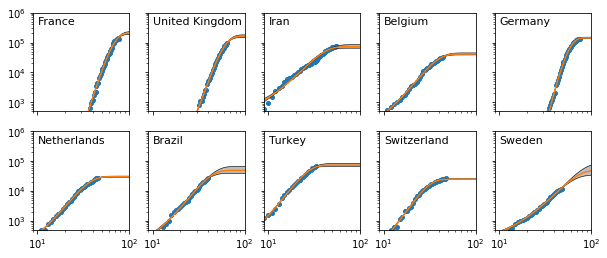

In [7]:
params_list = params_cases
data = cases
p0 = 500
daymin=-100
daymax=100
thresh = 500
c=0.95
drop_list = ['US','China','Italy','Spain']
current_fatalities = deaths.iloc[-1]
current_fatalities = current_fatalities.sort_index().drop(drop_list).loc[current_fatalities>thresh].sort_values(ascending=False)
top_countries = current_fatalities.index[:10]
t_pred = pd.to_datetime([datetime.today()+timedelta(days=k) for k in range(daymin,daymax)])

fig,ax=plt.subplots(2,5,sharey=True,sharex=True,figsize=((10,4)))
k = 0
ax = ax.reshape(-1)
for item in top_countries:
    train = data[item]
    params = params_list.loc[item].copy()
    f,a,params_good = plot_predictions(train,params,p0=p0,conf_type='sigma',log_scale=True,t_pred=t_pred,ax=ax[k],c=c)
    ax[k].set_xlabel('')
    ax[k].set_ylim((p0,1e6))
    ax[k].set_xlim((9,1e2))
    ax[k].text(0.05,0.88,item[0],fontsize=11,transform=ax[k].transAxes)
    k+=1
pdf = bpdf.PdfPages('figures/global_pred_cases.pdf')
pdf.savefig(fig)
pdf.close()
plt.show()

## US

New York
[9.88786478e+01 9.56907214e+00 7.33340064e+00 4.98140286e-03]
New Jersey
[1.05860401e+02 8.88450208e+00 9.13537366e+00 7.52441438e-03]
Michigan
[1.00942712e+02 7.91945177e+00 8.06580637e+00 3.37739378e-03]
Massachusetts
[1.14528016e+02 8.60115922e+00 1.15199643e+01 9.51790942e-03]
Louisiana
[9.96028801e+01 7.29688470e+00 9.37595514e+00 1.95544586e-03]
Illinois
[1.10857138e+02 8.12122791e+00 1.11927012e+01 6.69369296e-03]
Connecticut
[1.18200501e+02 8.62967690e+00 1.26702764e+01 2.53004190e-03]
California
[1.06524300e+02 7.54708531e+00 1.24341467e+01 9.44310003e-04]
Pennsylvania
[1.47398837e+02 1.15369207e+01 1.77418593e+01 5.26209353e-03]
Florida
[1.06786891e+02 7.28588075e+00 1.08918597e+01 1.05983670e-02]


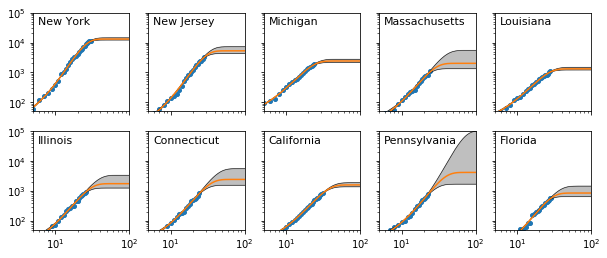

In [20]:
params_list = params_deaths.loc['US']
data = deaths['US']
p0 = 50
daymin=-100
daymax=100
c=0.95
current_fatalities = data.iloc[-1]
current_fatalities = current_fatalities.sort_index().drop('NaN').sort_values(ascending=False)
top_countries = current_fatalities.index[:10]
t_pred = pd.to_datetime([datetime.today()+timedelta(days=k) for k in range(daymin,daymax)])

fig,ax=plt.subplots(2,5,sharey=True,sharex=True,figsize=((10,4)))
k = 0
ax = ax.reshape(-1)
for item in top_countries:
    train = data[item]
    params = params_list.loc[item].copy()
    f,a,params_good = plot_predictions(train,params,p0=p0,conf_type='sigma',log_scale=True,t_pred=t_pred,ax=ax[k],c=c)
    ax[k].set_xlabel('')
    ax[k].set_ylim((p0,1e5))
    ax[k].set_xlim((5,1e2))
    ax[k].text(0.05,0.88,item,fontsize=11,transform=ax[k].transAxes)
    k+=1
pdf = bpdf.PdfPages('figures/US_pred.pdf')
pdf.savefig(fig)
pdf.close()
plt.show()

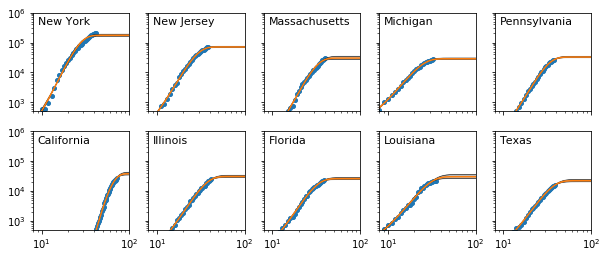

In [8]:
params_list = params_cases.loc['US']
data = cases['US']
p0 = 500
daymin=-100
daymax=100
c=0.95
current_fatalities = data.iloc[-1]
current_fatalities = current_fatalities.sort_index().drop('NaN').sort_values(ascending=False)
top_countries = current_fatalities.index[:10]
t_pred = pd.to_datetime([datetime.today()+timedelta(days=k) for k in range(daymin,daymax)])

fig,ax=plt.subplots(2,5,sharey=True,sharex=True,figsize=((10,4)))
k = 0
ax = ax.reshape(-1)
for item in top_countries:
    train = data[item]
    params = params_list.loc[item].copy()
    f,a,params_good = plot_predictions(train,params,p0=p0,conf_type='sigma',log_scale=True,t_pred=t_pred,ax=ax[k],c=c)
    ax[k].set_xlabel('')
    ax[k].set_ylim((500,1e6))
    ax[k].set_xlim((8,1e2))
    ax[k].text(0.05,0.88,item,fontsize=11,transform=ax[k].transAxes)
    k+=1
pdf = bpdf.PdfPages('figures/US_pred_cases.pdf')
pdf.savefig(fig)
pdf.close()
plt.show()

# Data collapse

## Fatalities

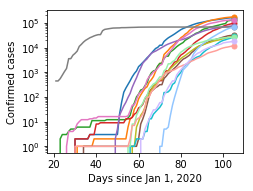

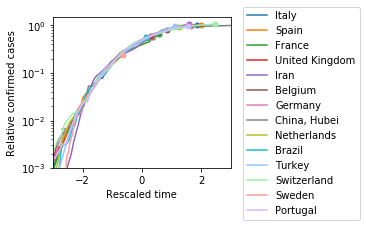

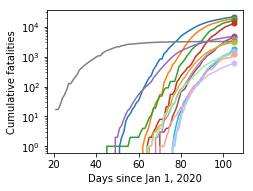

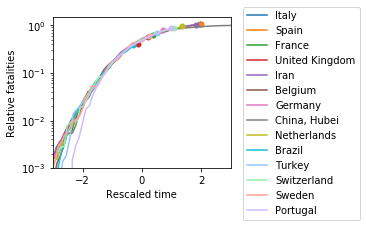

In [208]:
thresh = 500
current_fatalities = deaths.iloc[-1]
current_fatalities = current_fatalities.sort_index().drop('US').loc[current_fatalities>thresh].sort_values(ascending=False)
top_countries = current_fatalities.index
colors = sns.color_palette()+sns.color_palette('pastel')

fig,ax = data_collapse(cases,params_cases.loc[top_countries],scale=False,endpoint=True,ms=5,colors=colors)
#ax.set_ylim((1e-2,2))
#ax.set_xlim((-4,2))
ax.set_ylabel('Confirmed cases')
ax.set_xlabel('Days since Jan 1, 2020')
pdf = bpdf.PdfPages('figures/before_collapse_cases.pdf')
pdf.savefig(fig)
pdf.close()
plt.show()

fig,ax = data_collapse(cases,params_cases.loc[top_countries],endpoint=True,ms=5,colors=colors)
fig.set_figheight(3)
fig.set_figwidth(5.5)
#fig.subplots_adjust(right=1)
ax.set_ylim((1e-3,1.5))
ax.set_xlim((-3,3))
ax.set_ylabel('Relative confirmed cases')
ax.set_xlabel('Rescaled time')
ax.set_position([0.22,0.22,0.45,0.7])
ax.legend(loc='upper right',bbox_to_anchor=(1.75, 1.1))
pdf = bpdf.PdfPages('figures/after_collapse_cases.pdf')
pdf.savefig(fig)
pdf.close()
plt.show()

fig,ax = data_collapse(deaths,params_deaths.loc[top_countries],scale=False,endpoint=True,ms=5,colors=colors)
#ax.set_ylim((1e-2,2))
#ax.set_xlim((-4,2))
ax.set_ylabel('Cumulative fatalities')
ax.set_xlabel('Days since Jan 1, 2020')
pdf = bpdf.PdfPages('figures/before_collapse_deaths.pdf')
pdf.savefig(fig)
pdf.close()
plt.show()

fig,ax = data_collapse(deaths,params_deaths.loc[top_countries],endpoint=True,ms=5,colors=colors)
fig.set_figheight(3)
fig.set_figwidth(5.5)
#fig.subplots_adjust(right=1)
ax.set_ylim((1e-3,1.5))
ax.set_xlim((-3,3))
ax.set_ylabel('Relative fatalities')
ax.set_xlabel('Rescaled time')
ax.set_position([0.22,0.22,0.45,0.7])
ax.legend(loc='upper right',bbox_to_anchor=(1.75, 1.1))
pdf = bpdf.PdfPages('figures/after_collapse_deaths.pdf')
pdf.savefig(fig)
pdf.close()
plt.show()

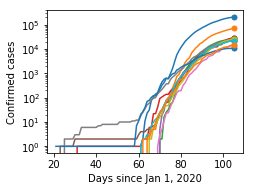

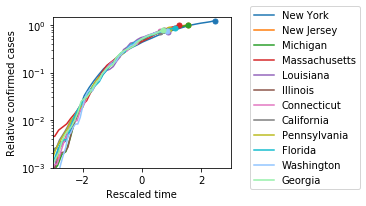

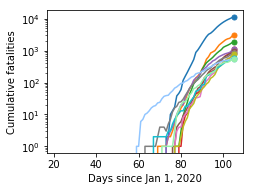

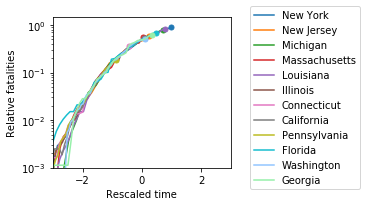

In [209]:
thresh = 500
current_fatalities = deaths['US'].iloc[-1]
current_fatalities = current_fatalities.loc[current_fatalities>thresh].sort_index().drop('NaN').sort_values(ascending=False)
top_countries = current_fatalities.index

fig,ax = data_collapse(cases['US'],params_cases.loc['US'].loc[top_countries],scale=False,endpoint=True,ms=5)
#ax.set_ylim((1e-2,2))
#ax.set_xlim((-4,2))
ax.set_ylabel('Confirmed cases')
ax.set_xlabel('Days since Jan 1, 2020')
pdf = bpdf.PdfPages('figures/before_collapse_cases_US.pdf')
pdf.savefig(fig)
pdf.close()
plt.show()

fig,ax = data_collapse(cases['US'],params_cases.loc['US'].loc[top_countries],endpoint=True,ms=5,colors=colors)
fig.set_figheight(3)
fig.set_figwidth(5.5)
#fig.subplots_adjust(right=1)
ax.set_ylim((1e-3,1.5))
ax.set_xlim((-3,3))
ax.set_ylabel('Relative confirmed cases')
ax.set_xlabel('Rescaled time')
ax.set_position([0.22,0.22,0.45,0.7])
ax.legend(loc='upper right',bbox_to_anchor=(1.75, 1.1))
pdf = bpdf.PdfPages('figures/after_collapse_cases_US.pdf')
pdf.savefig(fig)
pdf.close()
plt.show()

fig,ax = data_collapse(deaths['US'],params_deaths.loc['US'].loc[top_countries],scale=False,endpoint=True,ms=5,colors=colors)
#ax.set_ylim((1e-2,2))
#ax.set_xlim((-4,2))
ax.set_ylabel('Cumulative fatalities')
ax.set_xlabel('Days since Jan 1, 2020')
pdf = bpdf.PdfPages('figures/before_collapse_deaths_US.pdf')
pdf.savefig(fig)
pdf.close()
plt.show()

fig,ax = data_collapse(deaths['US'],params_deaths.loc['US'].loc[top_countries],endpoint=True,ms=5,colors=colors)
fig.set_figheight(3)
fig.set_figwidth(5.5)
#fig.subplots_adjust(right=1)
ax.set_ylim((1e-3,1.5))
ax.set_xlim((-3,3))
ax.set_ylabel('Relative fatalities')
ax.set_xlabel('Rescaled time')
ax.set_position([0.22,0.22,0.45,0.7])
ax.legend(loc='upper right',bbox_to_anchor=(1.75, 1.1))
pdf = bpdf.PdfPages('figures/after_collapse_deaths_US.pdf')
pdf.savefig(fig)
pdf.close()
plt.show()

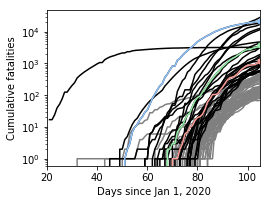

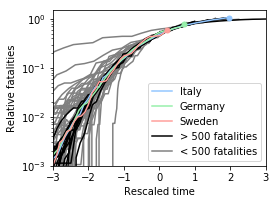

In [329]:
current_fatalities = deaths.iloc[-1]
fit_countries = list(set(current_fatalities.index.tolist()).intersection(set(params_deaths.index.tolist())))
nonfit_countries = list(set(current_fatalities.index.tolist())-set(fit_countries))
current_fatalities = current_fatalities.loc[fit_countries].sort_values(ascending=True)
select_countries = [('Italy','NaN'),('Germany','NaN'),('Sweden','NaN')]
top_countries = current_fatalities.index
colors_select = sns.color_palette('pastel')
#colors = sns.color_palette("husl", len(top_countries))
colors = ['gray']*(current_fatalities<=500).sum()+['black']*(current_fatalities>500).sum()

fig,ax=plt.subplots(figsize=(4,3))
fig.subplots_adjust(left=0.16,bottom=0.16)
f,ax = data_collapse(deaths,params_deaths.loc[top_countries],scale=False,ax=ax,colors=colors)
f,ax = data_collapse(deaths,params_deaths.loc[select_countries],ax=ax,colors=colors_select,scale=False,endpoint=True,ms=5)
#ax.plot((deaths.index-tref)/timedelta(days=1), deaths[nonfit_countries].values,'--',color='gray',alpha=1,linewidth=0.5)
#ax.set_ylim((1e-2,2))
ax.set_xlim((20,(deaths.index[-1]-tref)/timedelta(days=1)))
ax.set_ylabel('Cumulative fatalities')
ax.set_xlabel('Days since Jan 1, 2020')
pdf = bpdf.PdfPages('figures/before_collapse_deaths_all.pdf')
pdf.savefig(fig)
pdf.close()
plt.show()

fig,ax=plt.subplots(figsize=(4,3))
f,ax = data_collapse(deaths,params_deaths.loc[top_countries],ax=ax,colors=colors,labels=False,alpha=1)
f,ax = data_collapse(deaths,params_deaths.loc[select_countries],ax=ax,colors=colors_select,endpoint=True,ms=5)
#fig.set_figheight(3)
#fig.set_figwidth(5.5)
ax.plot([],[],'k',label='> 500 fatalities')
ax.plot([],[],'gray',label='< 500 fatalities')
fig.subplots_adjust(left=0.16,bottom=0.16)
ax.set_ylim((1e-3,1.5))
ax.set_xlim((-3,3))
ax.set_ylabel('Relative fatalities')
ax.set_xlabel('Rescaled time')
ax.legend()
#ax.set_position([0.22,0.22,0.45,0.7])
#ax.legend(loc='upper right',bbox_to_anchor=(1.75, 1.1))
pdf = bpdf.PdfPages('figures/after_collapse_deaths_all.pdf')
pdf.savefig(fig)
pdf.close()
plt.show()

## Cases

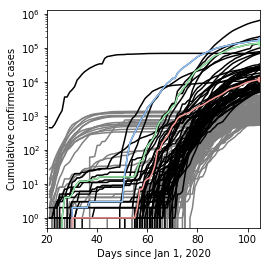

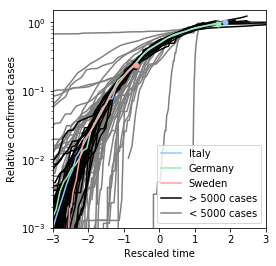

In [320]:
current_cases = cases.iloc[-1]
fit_countries = list(set(current_cases.index.tolist()).intersection(set(params_cases.index.tolist())))
nonfit_countries = list(set(current_cases.index.tolist())-set(fit_countries))
current_cases = current_cases.loc[fit_countries].sort_values(ascending=True)
top_countries = current_cases.index
select_countries = [('Italy','NaN'),('Germany','NaN'),('Sweden','NaN')]
colors_select = sns.color_palette('pastel')
#colors = sns.color_palette("husl", len(top_countries))
colors = ['gray']*(current_cases<=5000).sum()+['black']*(current_cases>5000).sum()

fig,ax=plt.subplots(figsize=(4,4))
fig.subplots_adjust(left=0.16)
f,ax = data_collapse(cases,params_cases.loc[top_countries],scale=False,ax=ax,colors=colors)
f,ax = data_collapse(cases,params_cases.loc[select_countries],scale=False,ax=ax,colors=colors_select,endpoint=True,ms=5)
#ax.plot((cases.index-tref)/timedelta(days=1), cases[nonfit_countries].values,'--',color='red',alpha=0.3)
#ax.set_ylim((1e-2,2))
ax.set_xlim((20,(deaths.index[-1]-tref)/timedelta(days=1)))
ax.set_ylabel('Cumulative confirmed cases')
ax.set_xlabel('Days since Jan 1, 2020')
pdf = bpdf.PdfPages('figures/before_collapse_cases.pdf')
pdf.savefig(fig)
pdf.close()
plt.show()

fig,ax=plt.subplots(figsize=(4,4))
f,ax = data_collapse(cases,params_cases.loc[top_countries],ax=ax,colors=colors,labels=False,alpha=1)
f,ax = data_collapse(cases,params_cases.loc[select_countries],ax=ax,colors=colors_select,endpoint=True,ms=5)
#fig.set_figheight(3)
#fig.set_figwidth(5.5)
fig.subplots_adjust(left=0.16)
ax.set_ylim((1e-3,1.5))
ax.set_xlim((-3,3))
ax.set_ylabel('Relative confirmed cases')
ax.set_xlabel('Rescaled time')
ax.plot([],[],'k',label='> 5000 cases')
ax.plot([],[],'gray',label='< 5000 cases')
ax.legend()
#ax.set_position([0.22,0.22,0.45,0.7])
#ax.legend(loc='upper right',bbox_to_anchor=(1.75, 1.1))
pdf = bpdf.PdfPages('figures/after_collapse_cases.pdf')
pdf.savefig(fig)
pdf.close()
plt.show()

# Simulations

In [24]:
#create a graph with degrees following a power law distribution
N=1000 
TG = 30
graphs = {'gamma_2.5':nx.expected_degree_graph(nx.utils.powerlaw_sequence(N, 2.5), selfloops=False),
          'gamma_3':nx.expected_degree_graph(nx.utils.powerlaw_sequence(N, 3), selfloops=False),
          'gamma_4':nx.expected_degree_graph(nx.utils.powerlaw_sequence(N, 4), selfloops=False),
          'ER_2.5':nx.gnp_random_graph(N, 2.5/N),
          'ER_5':nx.gnp_random_graph(N, 5/N),
          'ER_10':nx.gnp_random_graph(N, 10/N)}
sigG_list = {'Narrow waiting time distribution':TG/4,
            'Intermediate distribution':TG/2,
            'Broad waiting time distribution':TG}

tmax = 500
time_axis = [(datetime.today()-timedelta(days=tmax-k)).isoformat()[:10] for k in range(tmax)]
sim_data = pd.DataFrame(index=time_axis,columns=pd.MultiIndex.from_tuples([(item,name) for item in graphs.keys() for name in sigG_list.keys()]))


for item in sim_data.keys():
    print(item)
    t,cum_cases,t_in = simulate_pandemic_edges(graphs[item[0]],TG,sigG_list[item[1]],N_0=5,p=1,tmax=tmax,sampling='Gamma')
    sim_data[item] = cum_cases
sim_data.to_csv('simulation_small.csv')

('gamma_2.5', 'Narrow waiting time distribution')
Generation 0
Generation 1000
Generation 2000
Generation 3000
Generation 4000
Generation 5000
Generation 6000
Generation 7000
Generation 8000
Generation 9000
Generation 10000
Generation 11000
Generation 12000
Generation 13000
Generation 14000
Generation 15000
Generation 16000
Generation 17000
Generation 18000
Generation 19000
Generation 20000
('gamma_2.5', 'Intermediate distribution')
Generation 0
Generation 1000
Generation 2000
Generation 3000
Generation 4000
Generation 5000
Generation 6000
Generation 7000
Generation 8000
Generation 9000
Generation 10000
Generation 11000
Generation 12000
Generation 13000
Generation 14000
Generation 15000
Generation 16000
Generation 17000
Generation 18000
Generation 19000
Generation 20000
('gamma_2.5', 'Broad waiting time distribution')
Generation 0
Generation 1000
Generation 2000
Generation 3000
Generation 4000
Generation 5000
Generation 6000
Generation 7000
Generation 8000
Generation 9000
Generation 10

In [ ]:
sim = load_sim('simulation_small.csv')
k=0
start_cutoff=10
for item in sim.keys():
    print('----------'+item[0]+'-----------')
    data = sim[item]
    params,params0,success = fit_erf(data,p0=50)

    use_times = 120
    ter = 50

    ms = 4
    daymin=-500
    daymax=100
    t_pred = pd.to_datetime([datetime.today()+timedelta(days=k) for k in range(daymin,daymax)])

    fig,ax=plt.subplots(1,2,sharey=True,figsize=(6,2.5))
    fig.subplots_adjust(left=0.15,bottom=0.22,right=0.98)

    plot_data = data.loc[data>=start_cutoff]
    t0 = plot_data.index.values[0]
    plot_data.index = (plot_data.index-t0)/timedelta(days=1)
    plot_data = plot_data.loc[plot_data.index<use_times]
    t_plot = plot_data.index.values
    ax[1].loglog(t_plot,plot_data.values,'o',label='data',markersize=ms)
    ax[0].semilogy(t_plot,plot_data.values,'o',label='data',markersize=ms)

    fit_early = plot_data.iloc[:ter]
    fit_late = plot_data.iloc[20:]
    t_fit_early = fit_early.index.values
    t_fit_late = fit_late.index.values
    expo = LinearRegression()
    expo2 = LinearRegression()
    power = LinearRegression()
    X_all = plot_data.index.values[3:ter].reshape(-1,1)
    y_all = np.log(pd.to_numeric(plot_data).iloc[3:ter].values)
    X_early = t_fit_early.reshape(-1,1)
    X_late = t_fit_late.reshape(-1,1)
    y_early = np.log(pd.to_numeric(fit_early).values)
    y_late = np.log(pd.to_numeric(fit_late).values)
    expo.fit(X_early,y_early)
    #expo2.fit(X_late,y_late)
    power.fit(np.log(X_late),y_late)
    y_power = power.predict(np.log(X_late))
    y_exp = expo.predict(X_all)
    #exp_score2 = expo2.score(X_all,y_all)
    ax[1].loglog(X_late.reshape(-1),3*np.exp(y_power))
    ax[0].semilogy(X_all.reshape(-1),3*np.exp(y_exp))
    out = plot_predictions(data,params,ax=ax[2],log_scale=True,conf_type=None,p0=50,t_pred = t_pred,start_cutoff=start_cutoff)

    ax[0].set_xlabel('Elapsed time $t-t_0$ (days)')
    ax[1].set_xlabel('Elapsed time $t-t_0$ (days)')
    ax[2].set_xlabel('Elapsed time $t-t_0$ (days)')
    ax[0].set_ylabel('Cumulative cases')
    #ax[0].set_title(country+', '+region)
    ax[0].set_ylim((10,2e3))
    ax[1].set_title(item[1],fontsize=14)
    ax[2].legend()
    ax[0].set_xlim((1,use_times))
    ax[1].set_xlim((1,use_times))
    ax[2].set_xlim((1,None))

    pdf = bpdf.PdfPages('figures/example_'+item[0]+'_'.join(item[1].split(' '))+'.pdf')
    pdf.savefig(fig)
    pdf.close()
    plt.show()
    k+=1

----------gamma_2.5-----------


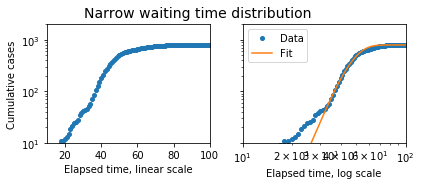

----------gamma_2.5-----------


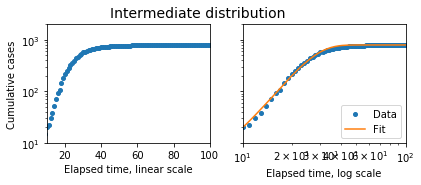

----------gamma_2.5-----------


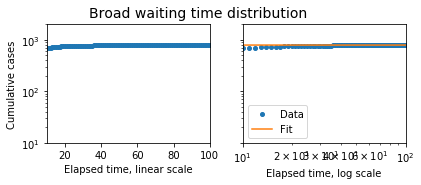

----------gamma_3-----------


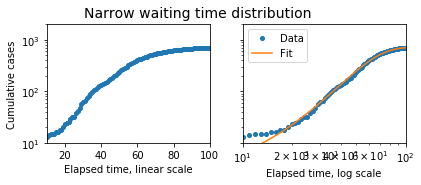

----------gamma_3-----------


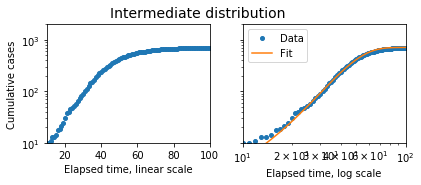

----------gamma_3-----------


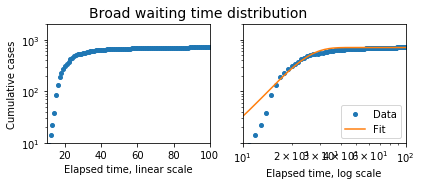

----------gamma_4-----------


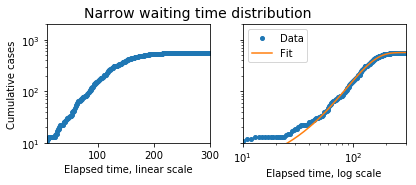

----------gamma_4-----------


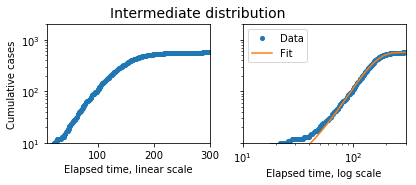

----------gamma_4-----------


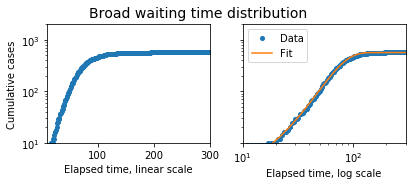

----------ER_2.5-----------


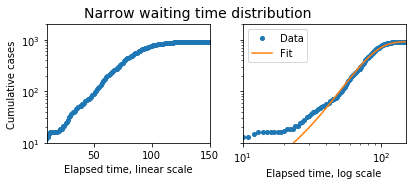

----------ER_2.5-----------


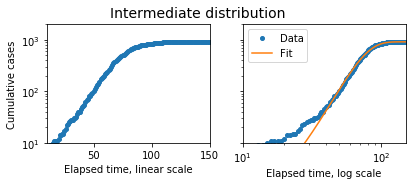

----------ER_2.5-----------


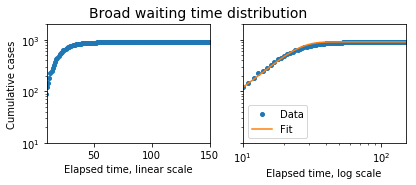

----------ER_5-----------


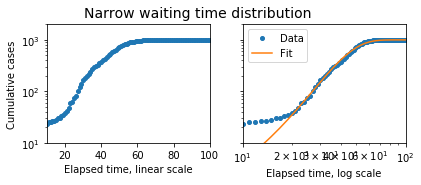

----------ER_5-----------


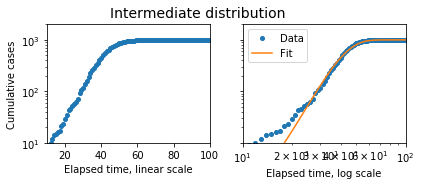

----------ER_5-----------


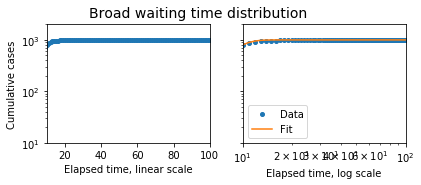

----------ER_10-----------


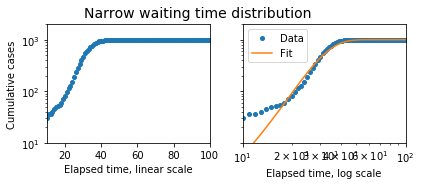

----------ER_10-----------


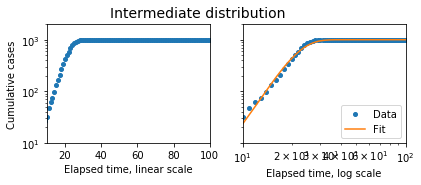

----------ER_10-----------


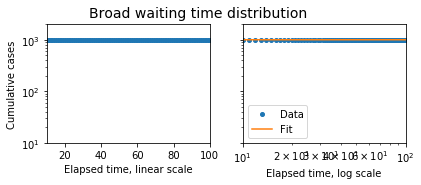

In [285]:
sim = load_sim('simulation_small.csv')
k=0
start_cutoff=6
for item in sim.keys():
    if item[0] == 'gamma_4':
        tmax = 300
    elif item[0] == 'ER_2.5':
        tmax = 150
    else:
        tmax = 100
    print('----------'+item[0]+'-----------')
    data = sim[item]
    params,params0,success = fit_erf(data,p0=50)

    ms = 4
    daymin=-500
    daymax=100
    t_pred = pd.to_datetime([datetime.today()+timedelta(days=k) for k in range(daymin,daymax)])

    fig,ax=plt.subplots(1,2,sharey=True,figsize=(6,2.5))
    fig.subplots_adjust(left=0.15,bottom=0.22,right=0.98)

    plot_data = data.loc[data>=start_cutoff]
    t0 = plot_data.index.values[0]
    plot_data.index = (plot_data.index-t0)/timedelta(days=1)
    t_plot = plot_data.index.values
    #ax[1].loglog(t_plot,plot_data.values,'o',label='data',markersize=ms)
    ax[0].semilogy(t_plot,plot_data.values,'o',label='data',markersize=ms)
    out = plot_predictions(data,params,ax=ax[1],log_scale=True,conf_type=None,p0=50,t_pred = t_pred,start_cutoff=start_cutoff)

    ax[0].set_xlabel('Elapsed time, linear scale')
    ax[1].set_xlabel('Elapsed time, log scale')
    ax[0].set_ylabel('Cumulative cases')
    #ax[0].set_title(country+', '+region)
    ax[0].set_ylim((10,2e3))
    fig.suptitle(item[1],fontsize=14)
    ax[1].legend()
    ax[0].set_xlim((10,tmax))
    ax[1].set_xlim((10,tmax))

    pdf = bpdf.PdfPages('figures/example_'+item[0]+'_'.join(item[1].split(' '))+'.pdf')
    pdf.savefig(fig)
    pdf.close()
    plt.show()
    k+=1

# Prediction is difficult until close to peak time

58.46160965098955
35.7850251294962
10.258714138185894
9.042534872625572
9.310317674274344


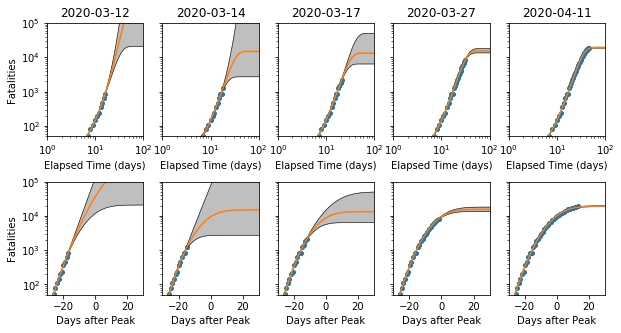

In [309]:
start_cutoff = 5
country = 'Italy'
region = 'NaN'
today = (datetime.today()-tref)/timedelta(days=1)
p0 = 50
daymin = -100
daymax = 100
t_pred = pd.to_datetime([datetime.today()+timedelta(days=k) for k in range(daymin,daymax)])
compute_err = True

data = deaths[country,region]
params,parm0,s = fit_erf(data,p0=p0)
th = params[0]

fig,ax=plt.subplots(2,5,figsize=(10,5),sharex=False,sharey=True)
fig.subplots_adjust(hspace=0.4)

k=0
for days_after in [-15,-13,-10,0,15]:
    mask = int(-today+th+days_after)
    params,parm0,s = fit_erf(data.iloc[:mask],p0=p0)
    f,a,params_good=plot_predictions(data.iloc[:mask],params,t_pred=t_pred,conf_type='sigma',th_true=th,ax=ax[0,k],
                                     p0=p0,log_scale=True,start_cutoff=start_cutoff,c=0.95)
    f,a,params_good=plot_predictions(data.iloc[:mask],params,t_pred=t_pred,conf_type='sigma',th_true=th,ax=ax[1,k],
                                     p0=p0,log_scale=False,c=0.95)
    print(params_good[-1,2])
    ax[0,k].set_ylim((p0,1e5))
    ax[1,k].set_ylim((p0,1e5))
    ax[0,k].set_xlim((1,100))
    ax[1,k].set_xlim((-30,30))
    ax[0,k].set_xlabel('Elapsed Time (days)')
    ax[1,k].set_xlabel('Days after Peak')
    ax[0,k].set_title((tref+timedelta(days=th+days_after)).isoformat()[:10])
    k+=1
ax[0,0].set_ylabel('Fatalities')
ax[1,0].set_ylabel('Fatalities')
pdf = bpdf.PdfPages('figures/'+country+'_forecasting.pdf')
pdf.savefig(fig)
pdf.close()
plt.show()

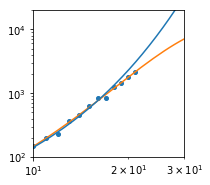

In [307]:
fig,ax=plt.subplots(figsize=(3,3))
fig.subplots_adjust(left=0.2,bottom=0.2)
p0 = 50
t0 = (data.loc[data>start_cutoff].index[0]-tref)/timedelta(days=1)
mask = int(-today+th-10)
params,parm0,s = fit_erf(data.iloc[:mask],p0=p0)
f,a,params_good=plot_predictions(data.iloc[:mask],params,t_pred=t_pred,conf_type=None,th_true=th,ax=ax,
                                 p0=p0,log_scale=True,start_cutoff=start_cutoff,c=0.95)
mask = int(-today+th-13)
params,parm0,s = fit_erf(data.iloc[:mask],p0=p0)
params_sweep = sweep_sigma(params,data.iloc[:mask],p0)
sigma,prob,scoremax = get_score_thresh(params_sweep,len(data.iloc[:mask].loc[data.iloc[:mask]>p0]),c)
params_good = params_sweep[params_sweep[:,3]<=scoremax]
t = np.linspace(1,200,1000)
tau = (t-params_good[-1,0])/params_good[-1,2]
ax.plot(t-t0,np.exp(params_good[-1,1])*norm.cdf(tau))
ax.set_xlim((10,30))
ax.set_ylim((1e2,2e4))
ax.set_xlabel('')
pdf = bpdf.PdfPages('figures/'+country+'_forecasting_in.pdf')
pdf.savefig(fig)
pdf.close()
plt.show()

252.12109086691646
260.7564607407143
254.96008876451089
245.3437722838548
214.80456905120985


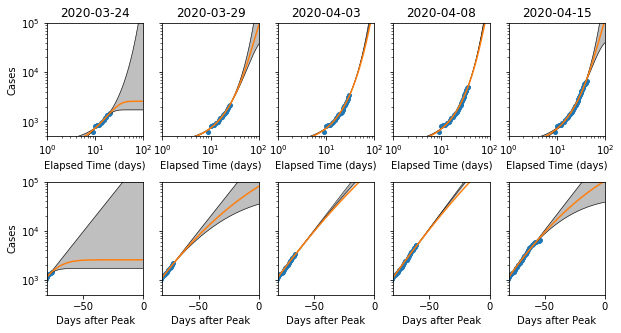

In [21]:
start_cutoff = 5
country = 'Denmark'
region = 'NaN'
today = (datetime.today()-tref)/timedelta(days=1)
p0 = 500
daymin = -100
daymax = 100
t_pred = pd.to_datetime([datetime.today()+timedelta(days=k) for k in range(daymin,daymax)])
compute_err = True

data = cases[country,region]
params,parm0,s = fit_erf(data,p0=p0)
th = params[0]

fig,ax=plt.subplots(2,5,figsize=(10,5),sharex=False,sharey=True)
fig.subplots_adjust(hspace=0.4)

k=0
for days_after in [-75,-70,-65,-60,-53]:
    mask = int(-today+th+days_after)
    params,parm0,s = fit_erf(data.iloc[:mask],p0=p0)
    f,a,params_good=plot_predictions(data.iloc[:mask],params,t_pred=t_pred,conf_type='sigma',th_true=th,ax=ax[0,k],
                                     p0=p0,log_scale=True,start_cutoff=start_cutoff,c=0.95)
    f,a,params_good=plot_predictions(data.iloc[:mask],params,t_pred=t_pred,conf_type='sigma',th_true=th,ax=ax[1,k],
                                     p0=p0,log_scale=False,c=0.95)
    print(params_good[-1,2])
    ax[0,k].set_ylim((p0,1e5))
    ax[1,k].set_ylim((p0,1e5))
    ax[0,k].set_xlim((1,100))
    ax[1,k].set_xlim((-80,0))
    ax[0,k].set_xlabel('Elapsed Time (days)')
    ax[1,k].set_xlabel('Days after Peak')
    ax[0,k].set_title((tref+timedelta(days=th+days_after)).isoformat()[:10])
    k+=1
ax[0,0].set_ylabel('Cases')
ax[1,0].set_ylabel('Cases')
plt.show()

# Parameters

## Plot countries

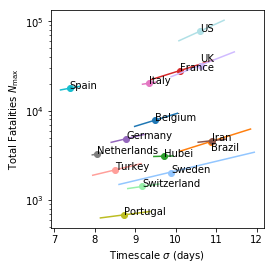

In [270]:
fig,ax=plt.subplots(figsize=(4,4))
fig.subplots_adjust(left=0.16)
current_fatalities = deaths.iloc[-1].sort_index().drop('US')
top_countries = current_fatalities.loc[current_fatalities>500].index.tolist()
colors = sns.color_palette()+sns.color_palette('pastel')
k=0
for item in top_countries:
    if item[0] == 'Brazil':
        ax.annotate(item[0],(predictions_deaths['sigma'].loc[item],0.8*predictions_deaths['Nmax'].loc[item]))
    elif item[0] == 'United Kingdom':
        ax.annotate('UK',(predictions_deaths['sigma'].loc[item],1.1*predictions_deaths['Nmax'].loc[item]))
    elif item[0] == 'China':
        ax.annotate('Hubei',(predictions_deaths['sigma'].loc[item],predictions_deaths['Nmax'].loc[item]))
    else:
        ax.annotate(item[0],(predictions_deaths['sigma'].loc[item],predictions_deaths['Nmax'].loc[item]))
    ax.semilogy([predictions_deaths['sigma_low'].loc[item],predictions_deaths['sigma_high'].loc[item]],[predictions_deaths['Nmax_low'].loc[item],predictions_deaths['Nmax_high'].loc[item]],color=colors[k])
    ax.semilogy([predictions_deaths['sigma'].loc[item]],[predictions_deaths['Nmax'].loc[item]],'o',color=colors[k],label=item[0])
    k+=1
k+=1
item = ('US','NaN')
ax.annotate('US',(predictions_deaths['sigma'].loc[item],predictions_deaths['Nmax'].loc[item]))
ax.semilogy([predictions_deaths['sigma_low'].loc[item],predictions_deaths['sigma_high'].loc[item]],[predictions_deaths['Nmax_low'].loc[item],predictions_deaths['Nmax_high'].loc[item]],color=colors[k])
ax.semilogy([predictions_deaths['sigma'].loc[item]],[predictions_deaths['Nmax'].loc[item]],'o',color=colors[k],label=item[0])
ax.set_xlabel(r'Timescale $\sigma$ (days)')
ax.set_ylabel(r'Total Fatalities $N_{\rm max}$')
pdf = bpdf.PdfPages('figures/top_world_scatter_sigma.pdf')
pdf.savefig(fig)
pdf.close()
plt.show()

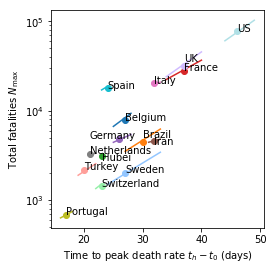

In [271]:
start_cutoff = 5
fig,ax=plt.subplots(figsize=(4,4))
fig.subplots_adjust(left=0.16)
current_fatalities = deaths.iloc[-1].sort_index().drop('US')
top_countries = current_fatalities.loc[current_fatalities>500].index.tolist()
colors = sns.color_palette()+sns.color_palette('pastel')

k=0
for item in top_countries:
    t0 = deaths.loc[deaths[item]>start_cutoff].index[0]
    tht0 = (predictions_deaths['th'].loc[item]-t0)/timedelta(days=1)
    tht0_low = (predictions_deaths['th_low'].loc[item]-t0)/timedelta(days=1)
    tht0_high = (predictions_deaths['th_high'].loc[item]-t0)/timedelta(days=1)
    if item[0] == 'United Kingdom':
        ax.annotate('UK',(tht0,1.1*predictions_deaths['Nmax'].loc[item]))
    elif item[0] == 'Germany':
        ax.annotate(item[0],(tht0-5,predictions_deaths['Nmax'].loc[item]))
    elif item[0] == 'China':
        ax.annotate('Hubei',(tht0,0.9*predictions_deaths['Nmax'].loc[item]))
    elif item[0] == 'Iran':
        ax.annotate(item[0],(tht0,0.9*predictions_deaths['Nmax'].loc[item]))
    elif item[0] == 'Brazil':
        ax.annotate(item[0],(tht0,1.1*predictions_deaths['Nmax'].loc[item]))
    else:
        ax.annotate(item[0],(tht0,predictions_deaths['Nmax'].loc[item]))
    ax.semilogy([tht0_low,tht0_high],[predictions_deaths['Nmax_low'].loc[item],predictions_deaths['Nmax_high'].loc[item]],color=colors[k])
    ax.semilogy([tht0],[predictions_deaths['Nmax'].loc[item]],'o',color=colors[k],label=item[0])
    k+=1
k+=1
item = ('US','NaN')
t0 = deaths.loc[deaths[item]>start_cutoff].index[0]
tht0 = (predictions_deaths['th'].loc[item]-t0)/timedelta(days=1)
tht0_low = (predictions_deaths['th_low'].loc[item]-t0)/timedelta(days=1)
tht0_high = (predictions_deaths['th_high'].loc[item]-t0)/timedelta(days=1)
ax.annotate('US',(tht0,predictions_deaths['Nmax'].loc[item]))
ax.semilogy([tht0_low,tht0_high],[predictions_deaths['Nmax_low'].loc[item],predictions_deaths['Nmax_high'].loc[item]],color=colors[k])
ax.semilogy([tht0],[predictions_deaths['Nmax'].loc[item]],'o',color=colors[k],label=item[0])
ax.set_xlabel(r'Time to peak death rate $t_h-t_0$ (days)')
ax.set_ylabel(r'Total fatalities $N_{\rm max}$')
pdf = bpdf.PdfPages('figures/top_world_scatter_th.pdf')
pdf.savefig(fig)
pdf.close()
plt.show()

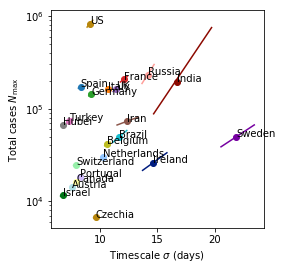

In [322]:
fig,ax=plt.subplots(figsize=(4,4))
fig.subplots_adjust(left=0.16)
current_cases = cases.iloc[-1].sort_index().drop(['US','Czechia','Korea, South'])
top_countries = current_cases.loc[current_cases>5000].sort_values(ascending=False).index.tolist()[:20]
k=0
colors = sns.color_palette()+sns.color_palette('pastel')+sns.color_palette('dark')
for item in top_countries:
    if item[0] == 'United Kingdom':
        ax.annotate('UK',(predictions_cases['sigma'].loc[item],predictions_cases['Nmax'].loc[item]))
    elif item[0] == 'China':
        ax.annotate('Hubei',(predictions_cases['sigma'].loc[item],predictions_cases['Nmax'].loc[item]))
    elif item[0] in ['Japan','Peru']:
        ax.annotate(item[0],(predictions_cases['sigma_low'].loc[item],predictions_cases['Nmax_low'].loc[item]))
    else:
        ax.annotate(item[0],(predictions_cases['sigma'].loc[item],predictions_cases['Nmax'].loc[item]))
    ax.semilogy([predictions_cases['sigma_low'].loc[item],predictions_cases['sigma_high'].loc[item]],[predictions_cases['Nmax_low'].loc[item],predictions_cases['Nmax_high'].loc[item]],color=colors[k])
    ax.semilogy([predictions_cases['sigma'].loc[item]],[predictions_cases['Nmax'].loc[item]],'o',color=colors[k],label=item[0])
    k+=1
item = ('US','NaN')
ax.annotate('US',(predictions_cases['sigma'].loc[item],predictions_cases['Nmax'].loc[item]))
ax.semilogy([predictions_cases['sigma_low'].loc[item],predictions_cases['sigma_high'].loc[item]],[predictions_cases['Nmax_low'].loc[item],predictions_cases['Nmax_high'].loc[item]],color=colors[k])
ax.semilogy([predictions_cases['sigma'].loc[item]],[predictions_cases['Nmax'].loc[item]],'o',color=colors[k],label=item[0])
item = ('Czechia','NaN')
ax.annotate('Czechia',(predictions_cases['sigma'].loc[item],predictions_cases['Nmax'].loc[item]))
ax.semilogy([predictions_cases['sigma_low'].loc[item],predictions_cases['sigma_high'].loc[item]],[predictions_cases['Nmax_low'].loc[item],predictions_cases['Nmax_high'].loc[item]],color=colors[k])
ax.semilogy([predictions_cases['sigma'].loc[item]],[predictions_cases['Nmax'].loc[item]],'o',color=colors[k],label=item[0])
#ax.set_ylim((500,1e6))
#ax.set_xlim((1,45))
ax.set_xlabel(r'Timescale $\sigma$ (days)')
ax.set_ylabel(r'Total cases $N_{\rm max}$')
pdf = bpdf.PdfPages('figures/top_world_scatter_cases.pdf')
pdf.savefig(fig)
pdf.close()
plt.show()

## Plot states

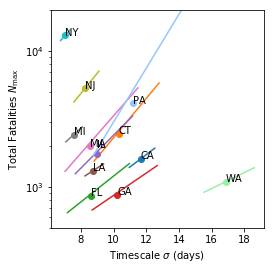

In [192]:
fig,ax=plt.subplots(figsize=(4,4))
fig.subplots_adjust(left=0.16)
current_fatalities = deaths.iloc[-1].loc['US'].sort_index().drop('NaN')
top_countries = current_fatalities.sort_index().loc[current_fatalities>500].index.tolist()
k=0
colors = sns.color_palette()+sns.color_palette('pastel')
for item in top_countries:
    if item == 'Illinois':
        ax.annotate(abbreviations[item],(predictions_deaths['sigma'].loc['US',item],1.1*predictions_deaths['Nmax'].loc['US',item]))
    else:
        ax.annotate(abbreviations[item],(predictions_deaths['sigma'].loc['US',item],predictions_deaths['Nmax'].loc['US',item]))
    ax.semilogy([predictions_deaths['sigma_low'].loc['US',item],predictions_deaths['sigma_high'].loc['US',item]],[predictions_deaths['Nmax_low'].loc['US',item],predictions_deaths['Nmax_high'].loc['US',item]],color=colors[k])
    ax.semilogy([predictions_deaths['sigma'].loc['US',item]],[predictions_deaths['Nmax'].loc['US',item]],'o',color=colors[k],label=item[0])
    k+=1
ax.set_xlabel(r'Timescale $\sigma$ (days)')
ax.set_ylabel(r'Total Fatalities $N_{\rm max}$')
ax.set_ylim((500,20000))
pdf = bpdf.PdfPages('figures/top_US_scatter.pdf')
pdf.savefig(fig)
pdf.close()
plt.show()

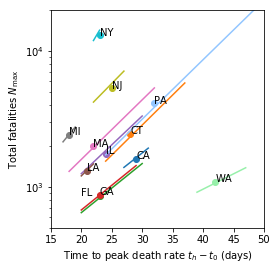

In [193]:
fig,ax=plt.subplots(figsize=(4,4))
fig.subplots_adjust(left=0.16)
current_fatalities = deaths.iloc[-1].loc['US'].sort_index().drop('NaN')
top_countries = current_fatalities.sort_index().loc[current_fatalities>500].index.tolist()
k=0
colors = sns.color_palette()+sns.color_palette('pastel')
for item in top_countries:
    t0 = deaths.loc[deaths['US',item]>start_cutoff].index[0]
    tht0 = (predictions_deaths['th'].loc['US',item]-t0)/timedelta(days=1)
    tht0_low = (predictions_deaths['th_low'].loc['US',item]-t0)/timedelta(days=1)
    tht0_high = (predictions_deaths['th_high'].loc['US',item]-t0)/timedelta(days=1)
    if item == 'Florida':
        ax.annotate(abbreviations[item],(tht0-3,predictions_deaths['Nmax'].loc['US',item]))
    else:
        ax.annotate(abbreviations[item],(tht0,predictions_deaths['Nmax'].loc['US',item]))
    ax.semilogy([tht0_low,tht0_high],[predictions_deaths['Nmax_low'].loc['US',item],predictions_deaths['Nmax_high'].loc['US',item]],color=colors[k])
    ax.semilogy([tht0],[predictions_deaths['Nmax'].loc['US',item]],'o',color=colors[k],label=item)
    k+=1
ax.set_xlabel(r'Time to peak death rate $t_h-t_0$ (days)')
ax.set_ylim((500,20000))
ax.set_xlim((15,50))
ax.set_ylabel(r'Total fatalities $N_{\rm max}$')
pdf = bpdf.PdfPages('figures/top_US_scatter_th.pdf')
pdf.savefig(fig)
pdf.close()
plt.show()

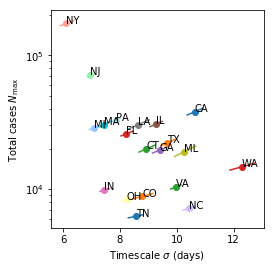

In [284]:
fig,ax=plt.subplots(figsize=(4,4))
fig.subplots_adjust(left=0.16)
current_cases = cases.iloc[-1].loc['US'].sort_index().drop('NaN')
top_countries = current_cases.sort_index().loc[current_cases>5000].index.tolist()
k=0
colors = (sns.color_palette()+sns.color_palette('pastel'))*10
for item in top_countries:
    ax.annotate(abbreviations[item],(predictions_cases['sigma'].loc['US',item],predictions_cases['Nmax'].loc['US',item]))
    ax.semilogy([predictions_cases['sigma_low'].loc['US',item],predictions_cases['sigma_high'].loc['US',item]],[predictions_cases['Nmax_low'].loc['US',item],predictions_cases['Nmax_high'].loc['US',item]],color=colors[k])
    ax.semilogy([predictions_cases['sigma'].loc['US',item]],[predictions_cases['Nmax'].loc['US',item]],'o',color=colors[k],label=item[0])
    k+=1
ax.set_xlabel(r'Timescale $\sigma$ (days)')
ax.set_ylabel(r'Total cases $N_{\rm max}$')
#ax.set_ylim((500,20000))
pdf = bpdf.PdfPages('figures/top_US_scatter_cases.pdf')
pdf.savefig(fig)
pdf.close()
plt.show()

## Color by current total number

### Fatalities

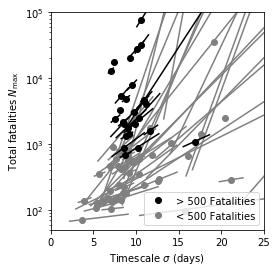

In [194]:
current_fatalities = deaths.iloc[-1].sort_index()
fit_countries = list(set(current_fatalities.index.tolist()).intersection(set(predictions_deaths.index.tolist())))
current_fatalities = current_fatalities.loc[fit_countries].sort_values(ascending=True)
select_countries = [('Italy','NaN'),('Germany','NaN'),('Sweden','NaN')]
top_countries = current_fatalities.index
colors_select = sns.color_palette('pastel')
colors = ['gray']*(current_fatalities<=500).sum()+['black']*(current_fatalities>500).sum()

fig,ax=plt.subplots(figsize=(4,4))
fig.subplots_adjust(left=0.16)
k=0
for item in top_countries:
    ax.semilogy([predictions_deaths['sigma_low'].loc[item],predictions_deaths['sigma_high'].loc[item]],[predictions_deaths['Nmax_low'].loc[item],predictions_deaths['Nmax_high'].loc[item]],color=colors[k])
    ax.semilogy([predictions_deaths['sigma'].loc[item]],[predictions_deaths['Nmax'].loc[item]],'o',color=colors[k])
    k+=1
ax.plot([],[],'o',color='k',label='> 500 Fatalities')
ax.plot([],[],'o',color='gray',label='< 500 Fatalities')
ax.legend()
ax.set_xlim((0,25))
ax.set_ylim((50,1e5))
ax.set_xlabel(r'Timescale $\sigma$ (days)')
ax.set_ylabel(r'Total fatalities $N_{\rm max}$')
pdf = bpdf.PdfPages('figures/all_scatter.pdf')
pdf.savefig(fig)
pdf.close()
#ax.legend()
plt.show()

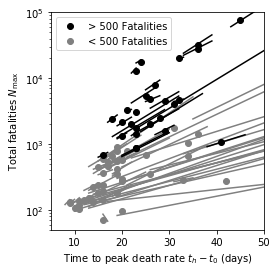

In [251]:
current_fatalities = deaths.iloc[-1].sort_index()
fit_countries = list(set(current_fatalities.index.tolist()).intersection(set(predictions_deaths.index.tolist())))
current_fatalities = current_fatalities.loc[fit_countries].sort_values(ascending=True)
select_countries = [('Italy','NaN'),('Germany','NaN'),('Sweden','NaN')]
top_countries = current_fatalities.index
colors_select = sns.color_palette('pastel')
colors = ['gray']*(current_fatalities<=500).sum()+['black']*(current_fatalities>500).sum()

fig,ax=plt.subplots(figsize=(4,4))
fig.subplots_adjust(left=0.16)
k=0
for item in top_countries:
    t0 = deaths.loc[deaths[item]>start_cutoff].index[0]
    tht0 = (predictions_deaths['th'].loc[item]-t0)/timedelta(days=1)
    tht0_low = (predictions_deaths['th_low'].loc[item]-t0)/timedelta(days=1)
    tht0_high = (predictions_deaths['th_high'].loc[item]-t0)/timedelta(days=1)

    ax.semilogy([tht0_low,tht0_high],[predictions_deaths['Nmax_low'].loc[item],predictions_deaths['Nmax_high'].loc[item]],color=colors[k])
    ax.semilogy([tht0],[predictions_deaths['Nmax'].loc[item]],'o',color=colors[k])
    k+=1
ax.plot([],[],'o',color='k',label='> 500 Fatalities')
ax.plot([],[],'o',color='gray',label='< 500 Fatalities')
ax.legend()
ax.set_xlim((5,50))
ax.set_ylim((50,1e5))
ax.set_xlabel(r'Time to peak death rate $t_h-t_0$ (days)')
ax.set_ylabel(r'Total fatalities $N_{\rm max}$')
pdf = bpdf.PdfPages('figures/all_scatter_th.pdf')
pdf.savefig(fig)
pdf.close()
#ax.legend()
plt.show()

### Cases

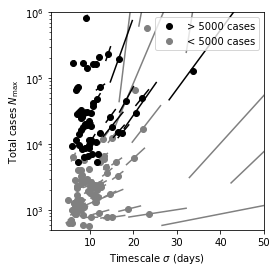

In [321]:
current_cases = cases.iloc[-1].sort_index()
fit_countries = list(set(current_cases.index.tolist()).intersection(set(predictions_cases.index.tolist())))
current_cases = current_cases.loc[fit_countries].sort_values(ascending=True)
top_countries = current_cases.index
colors = ['gray']*(current_cases<=5000).sum()+['black']*(current_cases>5000).sum()

fig,ax=plt.subplots(figsize=(4,4))
fig.subplots_adjust(left=0.16)
k=0
#colors = sns.color_palette()+sns.color_palette('pastel')
for item in top_countries:
    ax.semilogy([predictions_cases['sigma_low'].loc[item],predictions_cases['sigma_high'].loc[item]],[predictions_cases['Nmax_low'].loc[item],predictions_cases['Nmax_high'].loc[item]],color=colors[k])
    ax.semilogy([predictions_cases['sigma'].loc[item]],[predictions_cases['Nmax'].loc[item]],'o',color=colors[k])
    k+=1

ax.set_xlabel(r'Timescale $\sigma$ (days)')
ax.set_ylabel(r'Total cases $N_{\rm max}$')
ax.set_xlim((1,50))
ax.set_ylim((500,1e6))
ax.plot([],[],'o',color='k',label='> 5000 cases')
ax.plot([],[],'o',color='gray',label='< 5000 cases')
ax.legend()
pdf = bpdf.PdfPages('figures/top_world_scatter_cases_all.pdf')
pdf.savefig(fig)
pdf.close()
plt.show()

# Social policy

In [310]:
start_cutoff=5
month_numbers = {'jan':'01',
                 'feb':'02',
                 'mar':'03',
                 'apr':'04',
                 'may':'05'}

stringency = pd.read_excel('OxCGRT_timeseries_all.xlsx',sheet_name='stringencyindex',index_col=0).T.drop('CountryCode')
new_index = []
for k in range(len(stringency.index)):
    item = stringency.index[k]
    new_index.append('-'.join([item[-4:],month_numbers[item[2:5]],item[:2]]))
stringency.index = pd.to_datetime(new_index)

sd_time = pd.Series(np.ones(len(stringency.T))*np.nan,index=stringency.keys())
s_thresh=75
for item in sd_time.index:
    if (item,'NaN') in deaths.T.index.tolist():
        if (deaths[(item,'NaN')]>=start_cutoff).sum()>0:
            t0 = deaths[(item,'NaN')].loc[deaths[(item,'NaN')]>=start_cutoff].index[0]
            if (stringency[item]>s_thresh).sum()>0:
                sd_time.loc[item] = (stringency[item].loc[stringency[item]>s_thresh].index[0]-t0)/timedelta(days=1)
            else:
                sd_time.loc[item] = 1000
    elif item == 'China':
        t0 = deaths[(item,'Hubei')].loc[deaths[(item,'Hubei')]>=start_cutoff].index[0]
        sd_time.loc[item] = (stringency[item].loc[stringency[item]>s_thresh].index[0]-t0)/timedelta(days=1)
    elif item == 'United States':
        t0 = deaths[('US','NaN')].loc[deaths[('US','NaN')]>=start_cutoff].index[0]
        sd_time.loc[item] = (stringency[item].loc[stringency[item]>s_thresh].index[0]-t0)/timedelta(days=1)
        
work_close = pd.read_excel('OxCGRT_timeseries_all.xlsx',sheet_name='s2_workplaceclosing',index_col=0).T.drop('CountryCode')
new_index = []
for k in range(len(work_close.index)):
    item = work_close.index[k]
    new_index.append('-'.join([item[-4:],month_numbers[item[2:5]],item[:2]]))
work_close.index = pd.to_datetime(new_index)
work_time = pd.Series(np.ones(len(work_close.T))*np.nan,index=work_close.keys())
for item in work_time.index:
    if (item,'NaN') in deaths.T.index.tolist():
        if (deaths[(item,'NaN')]>=start_cutoff).sum()>0:
            if work_close[item].sum()>0:
                work_time.loc[item] = (work_close[item].loc[work_close[item]>0].index[0]
                                     -deaths[(item,'NaN')].loc[deaths[(item,'NaN')]>=start_cutoff].index[0])/timedelta(days=1)
            else:
                work_time.loc[item] = (work_close.index[-1]-deaths[(item,'NaN')].loc[deaths[(item,'NaN')]>=start_cutoff].index[0])/timedelta(days=1)

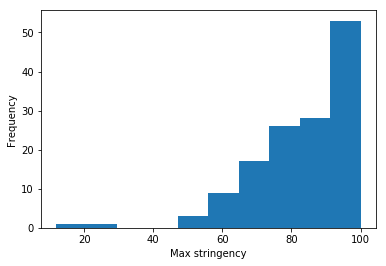

/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3405: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)


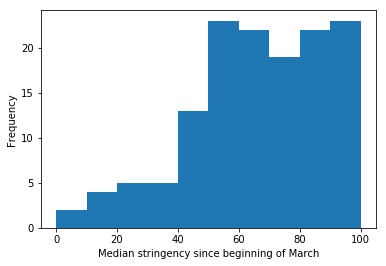

In [155]:
stringency.max().plot.hist()
plt.gca().set_xlabel('Max stringency')
plt.show()

stringency.loc[datetime(2020,3,1):].median().plot.hist()
plt.gca().set_xlabel('Median stringency since beginning of March')
plt.show()

/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3405: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)


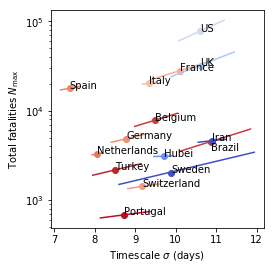

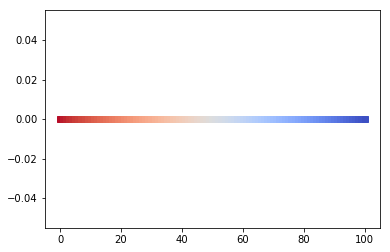

In [337]:
strin_score_med = stringency.loc[datetime(2020,3,1):].median()
strin_score_max = stringency.max()

cutoff = 0
smax = 40
strin_score = sd_time
strin_score = strin_score-cutoff
strin_score.loc[strin_score<0] = 0
strin_score = 100*strin_score/(smax-cutoff)
strin_score[strin_score>100] = 100
colors = sns.color_palette('coolwarm_r',101)

ms = 6
fig,ax=plt.subplots(figsize=(4,4))
fig.subplots_adjust(left=0.16)
current_fatalities = deaths.iloc[-1].sort_index().drop('US')
top_countries = current_fatalities.loc[current_fatalities>500].index.tolist()
k=0
#colors = sns.color_palette()+sns.color_palette('pastel')
for item in top_countries:
    if item[0] == 'Brazil':
        ax.annotate(item[0],(predictions_deaths['sigma'].loc[item],0.8*predictions_deaths['Nmax'].loc[item]))
    elif item[0] == 'China':
        ax.annotate('Hubei',(predictions_deaths['sigma'].loc[item],predictions_deaths['Nmax'].loc[item]))
    elif item[0] == 'United Kingdom':
        ax.annotate('UK',(predictions_deaths['sigma'].loc[item],predictions_deaths['Nmax'].loc[item]))
    else:
        ax.annotate(item[0],(predictions_deaths['sigma'].loc[item],predictions_deaths['Nmax'].loc[item]))
    ax.semilogy([predictions_deaths['sigma_low'].loc[item],predictions_deaths['sigma_high'].loc[item]],[predictions_deaths['Nmax_low'].loc[item],predictions_deaths['Nmax_high'].loc[item]],color=colors[int(strin_score.loc[item[0]])])
    ax.semilogy([predictions_deaths['sigma'].loc[item]],[predictions_deaths['Nmax'].loc[item]],'o',color=colors[int(strin_score.loc[item[0]])],label=item[0],markersize=ms)
    k+=1
item = ('US','NaN')
ax.annotate('US',(predictions_deaths['sigma'].loc[item],predictions_deaths['Nmax'].loc[item]))
ax.semilogy([predictions_deaths['sigma_low'].loc[item],predictions_deaths['sigma_high'].loc[item]],[predictions_deaths['Nmax_low'].loc[item],predictions_deaths['Nmax_high'].loc[item]],color=colors[int(strin_score.loc['United States'])])
ax.semilogy([predictions_deaths['sigma'].loc[item]],[predictions_deaths['Nmax'].loc[item]],'o',color=colors[int(strin_score.loc['United States'])],label=item[0],markersize=ms)
ax.set_xlabel(r'Timescale $\sigma$ (days)')
ax.set_ylabel(r'Total fatalities $N_{\rm max}$')
pdf = bpdf.PdfPages('figures/top_world_scatter_str_time.pdf')
pdf.savefig(fig)
pdf.close()
plt.show()

fig,ax=plt.subplots()
klist = np.arange(101)
for k in klist:
    ax.plot([k],[0],'s',color=colors[k])
pdf = bpdf.PdfPages('figures/colorbar.pdf')
pdf.savefig(fig)
pdf.close()
plt.show()

/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3405: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)


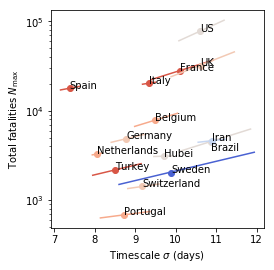

In [338]:
strin_score_med = stringency.loc[datetime(2020,3,1):].median()
strin_score_max = stringency.max()

cutoff = 50
smax = 100
strin_score = strin_score_max
strin_score = strin_score-cutoff
strin_score.loc[strin_score<0] = 0
strin_score = 100*strin_score/(smax-cutoff)
strin_score[strin_score>100] = 100
colors = sns.color_palette('coolwarm',101)

ms = 6
fig,ax=plt.subplots(figsize=(4,4))
fig.subplots_adjust(left=0.16)
current_fatalities = deaths.iloc[-1].sort_index().drop('US')
top_countries = current_fatalities.loc[current_fatalities>500].index.tolist()
k=0
#colors = sns.color_palette()+sns.color_palette('pastel')
for item in top_countries:
    if item[0] == 'Brazil':
        ax.annotate(item[0],(predictions_deaths['sigma'].loc[item],0.8*predictions_deaths['Nmax'].loc[item]))
    elif item[0] == 'United Kingdom':
        ax.annotate('UK',(predictions_deaths['sigma'].loc[item],predictions_deaths['Nmax'].loc[item]))
    elif item[0] == 'China':
        ax.annotate('Hubei',(predictions_deaths['sigma'].loc[item],predictions_deaths['Nmax'].loc[item]))
    else:
        ax.annotate(item[0],(predictions_deaths['sigma'].loc[item],predictions_deaths['Nmax'].loc[item]))
    ax.semilogy([predictions_deaths['sigma_low'].loc[item],predictions_deaths['sigma_high'].loc[item]],[predictions_deaths['Nmax_low'].loc[item],predictions_deaths['Nmax_high'].loc[item]],color=colors[int(strin_score.loc[item[0]])])
    ax.semilogy([predictions_deaths['sigma'].loc[item]],[predictions_deaths['Nmax'].loc[item]],'o',color=colors[int(strin_score.loc[item[0]])],label=item[0],markersize=ms)
    k+=1
item = ('US','NaN')
ax.annotate('US',(predictions_deaths['sigma'].loc[item],predictions_deaths['Nmax'].loc[item]))
ax.semilogy([predictions_deaths['sigma_low'].loc[item],predictions_deaths['sigma_high'].loc[item]],[predictions_deaths['Nmax_low'].loc[item],predictions_deaths['Nmax_high'].loc[item]],color=colors[int(strin_score.loc['United States'])])
ax.semilogy([predictions_deaths['sigma'].loc[item]],[predictions_deaths['Nmax'].loc[item]],'o',color=colors[int(strin_score.loc['United States'])],label=item[0],markersize=ms)
ax.set_xlabel(r'Timescale $\sigma$ (days)')
ax.set_ylabel(r'Total fatalities $N_{\rm max}$')
pdf = bpdf.PdfPages('figures/top_world_scatter_str.pdf')
pdf.savefig(fig)
pdf.close()
plt.show()

/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3405: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)


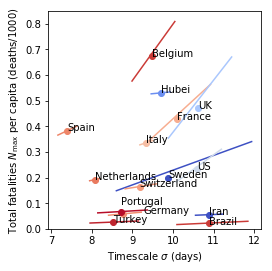

In [339]:
populations = pd.to_numeric(pd.read_csv('populations.csv').fillna(value='NaN').set_index(['Country/Region','Province/State']).squeeze())
strin_score_med = stringency.loc[datetime(2020,3,1):].median()
strin_score_max = stringency.max()

cutoff = 0
smax = 40
strin_score = sd_time
strin_score = strin_score-cutoff
strin_score.loc[strin_score<0] = 0
strin_score = 100*strin_score/(smax-cutoff)
strin_score[strin_score>100] = 100
colors = sns.color_palette('coolwarm_r',101)

ms=6
fig,ax=plt.subplots(figsize=(4,4))
fig.subplots_adjust(left=0.16)
current_fatalities = deaths.iloc[-1].sort_index().drop('US')
top_countries = current_fatalities.loc[current_fatalities>500].index.tolist()
predictions_pc = predictions_deaths.copy().loc[top_countries]
for item in ['Nmax','Nmax_low','Nmax_high']:
    predictions_pc[item] = 1000*predictions_pc[item]/populations.loc[predictions_pc.index.tolist()]
k=0
#colors = sns.color_palette()+sns.color_palette('pastel')
for item in top_countries:
    if item[0] == 'Brazil':
        ax.annotate(item[0],(predictions_pc['sigma'].loc[item],0.8*predictions_pc['Nmax'].loc[item]))
    elif item[0] == 'China':
        ax.annotate('Hubei',(predictions_pc['sigma'].loc[item],predictions_pc['Nmax'].loc[item]))
    elif item[0] == 'Portugal':
        ax.annotate(item[0],(predictions_pc['sigma'].loc[item],1.4*predictions_pc['Nmax'].loc[item]))
    elif item[0] == 'Germany':
        ax.annotate(item[0],(0.5+predictions_pc['sigma'].loc[item],predictions_pc['Nmax'].loc[item]))
    elif item[0] == 'United Kingdom':
        ax.annotate('UK',(predictions_pc['sigma'].loc[item],predictions_pc['Nmax'].loc[item]))
    else:
        ax.annotate(item[0],(predictions_pc['sigma'].loc[item],predictions_pc['Nmax'].loc[item]))
    ax.plot([predictions_pc['sigma_low'].loc[item],predictions_pc['sigma_high'].loc[item]],[predictions_pc['Nmax_low'].loc[item],predictions_pc['Nmax_high'].loc[item]],color=colors[int(strin_score.loc[item[0]])])
    ax.plot([predictions_pc['sigma'].loc[item]],[predictions_pc['Nmax'].loc[item]],'o',color=colors[int(strin_score.loc[item[0]])],label=item[0],markersize=ms)
    k+=1
item = ('US','NaN')
predictions_pc = predictions_deaths.copy().loc[item]
for col in ['Nmax','Nmax_low','Nmax_high']:
    predictions_pc[col] = 1000*predictions_pc[col]/populations.loc[item]
ax.annotate('US',(predictions_pc['sigma'],predictions_pc['Nmax']))
ax.plot([predictions_pc['sigma_low'],predictions_pc['sigma_high']],[predictions_pc['Nmax_low'],predictions_pc['Nmax_high']],color=colors[int(strin_score.loc['United States'])])
ax.plot([predictions_pc['sigma']],[predictions_pc['Nmax']],'o',color=colors[int(strin_score.loc['United States'])],label=item[0],markersize=ms)
ax.set_xlabel(r'Timescale $\sigma$ (days)')
ax.set_ylabel(r'Total fatalities $N_{\rm max}$ per capita (deaths/1000)')
ax.set_ylim((0,None))
pdf = bpdf.PdfPages('figures/top_world_scatter_str_time_pc.pdf')
pdf.savefig(fig)
pdf.close()
plt.show()

/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3405: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)


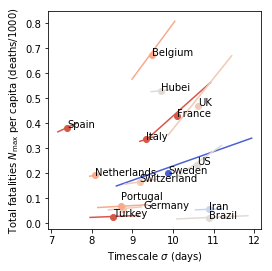

In [340]:
populations = pd.to_numeric(pd.read_csv('populations.csv').fillna(value='NaN').set_index(['Country/Region','Province/State']).squeeze())
strin_score_med = stringency.loc[datetime(2020,3,1):].median()
strin_score_max = stringency.max()

cutoff = 50
smax = 100
strin_score = strin_score_max
strin_score = strin_score-cutoff
strin_score.loc[strin_score<0] = 0
strin_score = 100*strin_score/(smax-cutoff)
strin_score[strin_score>100] = 100
colors = sns.color_palette('coolwarm',101)

ms = 6
fig,ax=plt.subplots(figsize=(4,4))
fig.subplots_adjust(left=0.16)
current_fatalities = deaths.iloc[-1].sort_index().drop('US')
top_countries = current_fatalities.loc[current_fatalities>500].index.tolist()
predictions_pc = predictions_deaths.copy().loc[top_countries]
for item in ['Nmax','Nmax_low','Nmax_high']:
    predictions_pc[item] = 1000*predictions_pc[item]/populations.loc[predictions_pc.index.tolist()]
k=0
#colors = sns.color_palette()+sns.color_palette('pastel')
for item in top_countries:
    if item[0] == 'Brazil':
        ax.annotate(item[0],(predictions_pc['sigma'].loc[item],0.8*predictions_pc['Nmax'].loc[item]))
    elif item[0] == 'China':
        ax.annotate('Hubei',(predictions_pc['sigma'].loc[item],predictions_pc['Nmax'].loc[item]))
    elif item[0] == 'Portugal':
        ax.annotate(item[0],(predictions_pc['sigma'].loc[item],1.4*predictions_pc['Nmax'].loc[item]))
    elif item[0] == 'Germany':
        ax.annotate(item[0],(0.5+predictions_pc['sigma'].loc[item],predictions_pc['Nmax'].loc[item]))
    elif item[0] == 'United Kingdom':
        ax.annotate('UK',(predictions_pc['sigma'].loc[item],predictions_pc['Nmax'].loc[item]))
    else:
        ax.annotate(item[0],(predictions_pc['sigma'].loc[item],predictions_pc['Nmax'].loc[item]))
    ax.plot([predictions_pc['sigma_low'].loc[item],predictions_pc['sigma_high'].loc[item]],[predictions_pc['Nmax_low'].loc[item],predictions_pc['Nmax_high'].loc[item]],color=colors[int(strin_score.loc[item[0]])])
    ax.plot([predictions_pc['sigma'].loc[item]],[predictions_pc['Nmax'].loc[item]],'o',color=colors[int(strin_score.loc[item[0]])],label=item[0],markersize=ms)
    k+=1
item = ('US','NaN')
predictions_pc = predictions_deaths.copy().loc[item]
for col in ['Nmax','Nmax_low','Nmax_high']:
    predictions_pc[col] = 1000*predictions_pc[col]/populations.loc[item]
ax.annotate('US',(predictions_pc['sigma'],predictions_pc['Nmax']))
ax.plot([predictions_pc['sigma_low'],predictions_pc['sigma_high']],[predictions_pc['Nmax_low'],predictions_pc['Nmax_high']],color=colors[int(strin_score.loc['United States'])])
ax.plot([predictions_pc['sigma']],[predictions_pc['Nmax']],'o',color=colors[int(strin_score.loc['United States'])],label=item[0],markersize=ms)
ax.set_xlabel(r'Timescale $\sigma$ (days)')
ax.set_ylabel(r'Total fatalities $N_{\rm max}$ per capita (deaths/1000)')
pdf = bpdf.PdfPages('figures/top_world_scatter_str_pc.pdf')
pdf.savefig(fig)
pdf.close()
plt.show()

# Compare predictions

In [311]:
IHME = pd.read_csv('2020_04_12.02/Hospitalization_all_locs.csv')
IHME['date'] = pd.to_datetime(IHME['date'],format='%Y-%m-%d')
IHME_predictions = pd.DataFrame(index=predictions_deaths.index,columns=['Nmax','Nmax_low','Nmax_high','th','th_low','th_high'])
Nmax = IHME.pivot_table(index='date',values='totdea_mean',columns='location_name').max()
Nmax_high = IHME.pivot_table(index='date',values='totdea_upper',columns='location_name').max()
Nmax_low = IHME.pivot_table(index='date',values='totdea_lower',columns='location_name').max()
th = (IHME.pivot_table(index='date',values='deaths_mean',columns='location_name').idxmax()).dt.strftime('%Y-%m-%d')
th_high = (IHME.pivot_table(index='date',values='deaths_upper',columns='location_name').idxmax())
th_low = (IHME.pivot_table(index='date',values='deaths_lower',columns='location_name').idxmax())
for name in set(IHME['location_name']):
    if name in deaths.T.loc['US'].index.tolist():
        item = ('US',name)
    else:
        item = (name,'NaN')
    if item in IHME_predictions.index.tolist():
        IHME_predictions.loc[item] = [Nmax.loc[name],Nmax_low.loc[name],Nmax_high.loc[name],
                                      th.loc[name],th_low.loc[name],th_high.loc[name]]
IHME_predictions.to_csv('IHME_predictions.csv')

## World

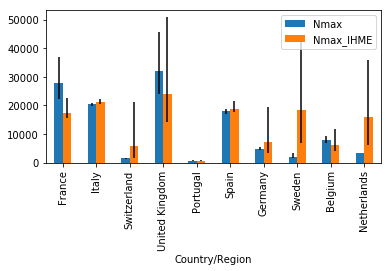

In [153]:
current_fatalities = deaths.iloc[-1].sort_index().drop('US')
top_countries = current_fatalities.loc[current_fatalities>500].reset_index().set_index('Country/Region').index.tolist()
pred_compare = predictions_deaths.join(IHME_predictions,rsuffix='_IHME').dropna().reset_index().T.drop('Province/State').T.set_index('Country/Region')
valid_regions = list(set(top_countries).intersection(set(pred_compare.index.tolist())))

pred_plot = pred_compare[['Nmax','Nmax_IHME']].loc[valid_regions]
bottom = pred_plot['Nmax'].values - pred_compare['Nmax_low'].loc[valid_regions].values
top = pred_compare['Nmax_high'].loc[valid_regions].values - pred_plot['Nmax'].values
bottom_IHME = pred_plot['Nmax_IHME'].values - pred_compare['Nmax_low_IHME'].loc[valid_regions].values
top_IHME = pred_compare['Nmax_high_IHME'].loc[valid_regions].values - pred_plot['Nmax_IHME'].values
pred_err = np.asarray([np.vstack((bottom.T,top.T)),np.vstack((bottom_IHME.T,top_IHME.T))])

fig,ax=plt.subplots()
fig.subplots_adjust(bottom=0.35)
pred_plot.plot.bar(ax=ax,yerr=pred_err)
pdf = bpdf.PdfPages('figures/IHME_world.pdf')
pdf.savefig(fig)
pdf.close()
plt.show()

## US

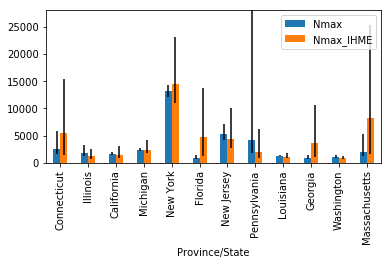

In [109]:
current_fatalities = deaths.iloc[-1].sort_index().loc['US'].drop('NaN')
top_countries = current_fatalities.loc[current_fatalities>500].index.tolist()
pred_compare = predictions_deaths.join(IHME_predictions,rsuffix='_IHME').dropna().reset_index().T.drop('Country/Region').T.set_index('Province/State')
valid_regions = list(set(top_countries).intersection(set(pred_compare.index.tolist())))

pred_plot = pred_compare[['Nmax','Nmax_IHME']].loc[valid_regions]
bottom = pred_plot['Nmax'].values - pred_compare['Nmax_low'].loc[valid_regions].values
top = pred_compare['Nmax_high'].loc[valid_regions].values - pred_plot['Nmax'].values
bottom_IHME = pred_plot['Nmax_IHME'].values - pred_compare['Nmax_low_IHME'].loc[valid_regions].values
top_IHME = pred_compare['Nmax_high_IHME'].loc[valid_regions].values - pred_plot['Nmax_IHME'].values
pred_err = np.asarray([np.vstack((bottom.T,top.T)),np.vstack((bottom_IHME.T,top_IHME.T))])

fig,ax=plt.subplots()
fig.subplots_adjust(bottom=0.35)
pred_plot.plot.bar(ax=ax,yerr=pred_err)
ax.set_ylim((None,28000))
pdf = bpdf.PdfPages('figures/IHME_US.pdf')
pdf.savefig(fig)
pdf.close()
plt.show()

# Methods

First, we show that the distribution is effectively one-dimensional

In [231]:
country = 'Italy'
region = 'NaN'

today = (deaths.index[-1]-tref)/timedelta(days=1)
th = params_deaths.loc[country,region]['th']
days_back=15
mask = int(today-th+days_back)

data = deaths[country,region].iloc[:-mask]
p0 = 50
params,parm0,s = fit_erf(data,p0=p0)
train = pd.to_numeric(data.loc[data>p0])
train.index=(train.index-tref)/timedelta(days=1)
sig_xi2 = params[-1]
H = hess_p(params[:-1],train,None)
print(np.linalg.eig(H))
H = np.linalg.inv(H)[1:,:]
H = np.linalg.inv(H[:,1:])

(array([1.73530006e+01, 9.11599501e-05, 3.57590112e-01]), array([[ 0.2374368 , -0.96733364, -0.08882232],
       [-0.82796713, -0.15370916, -0.53929948],
       [-0.50802973, -0.2015915 ,  0.83741666]]))


In [232]:
delta = 0.1
sigma = np.arange(1, 15, delta)
logK = np.arange(1, 15, delta)
X, Y = np.meshgrid(sigma, logK)
logK0 = params[1]
sig0 = params[2]
C = [[(np.asarray([Y[j,k]-logK0,X[j,k]-sig0])[np.newaxis,:].dot(H.dot(np.asarray([Y[j,k]-logK0,X[j,k]-sig0])))).squeeze() 
      for k in range(len(X.T))] for j in range(len(X))]

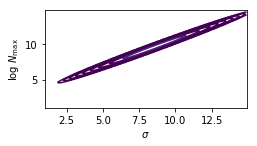

In [244]:
fig,ax=plt.subplots(figsize=(4,2))
fig.subplots_adjust(bottom=0.2,left=0.2)
levels = np.logspace(-9,0,10)
ax.contour(X,Y,np.exp(-np.asarray(C/sig_xi2)),levels=levels)
ax.set_xlabel(r'$\sigma$')
ax.set_ylabel(r'log $N_{\rm max}$')
pdf = bpdf.PdfPages('figures/hessian.pdf')
pdf.savefig(fig)
pdf.close()
plt.show()

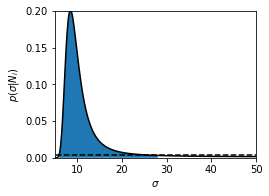

In [243]:
fig,ax=plt.subplots(figsize=(4,3))
fig.subplots_adjust(bottom=0.2,left=0.2)
c = 0.95
M = len(train)
params_sweep = sweep_sigma(params,data,p0)
sigma, prob,scoremax = get_score_thresh(params_sweep,M,0.95)
ax.plot(sigma,prob,'k')
score = params_sweep[1:,3]
ax.fill_between(sigma[score<=scoremax],prob[score<=scoremax])

sigma = params_sweep[:,2]
dsig = np.diff(sigma)
sigma = sigma[1:]
pcut = np.exp(-scoremax*M/(2*sig_xi2))/(np.exp(-score*M/(2*sig_xi2))*dsig).sum()
ax.plot([0,50],[pcut,pcut],'k--')

ax.set_xlabel(r'$\sigma$')
ax.set_ylabel(r'$p(\sigma|N_i)$')
ax.set_xlim((5,50))
ax.set_ylim((0,0.2))
pdf = bpdf.PdfPages('figures/psig.pdf')
pdf.savefig(fig)
pdf.close()
plt.show()
plt.show()

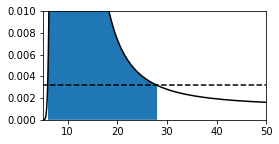

In [241]:
fig,ax=plt.subplots(figsize=(4,2))
ax.plot(sigma,prob,'k')
ax.fill_between(sigma[score<=scoremax],prob[score<=scoremax])
pcut = np.exp(-scoremax*M/(2*sig_xi2))/(np.exp(-score*M/(2*sig_xi2))*dsig).sum()
ax.plot([0,50],[pcut,pcut],'k--')

#ax.set_xlabel(r'$\sigma$')
#ax.set_ylabel(r'$p(\sigma|N_i)$')
ax.set_xlim((5,50))
ax.set_ylim((0,0.01))
pdf = bpdf.PdfPages('figures/psig_in.pdf')
pdf.savefig(fig)
pdf.close()
plt.show()
plt.show()